# Name: Sergiy Goloviatinski

# Assignment 2 ATML 2020
## Classification with limited data
ImageNet is a well known dataset with 1000 image classes. We will be working on a subset of the dataset (60k images, 100 classes, 600 images per class 80$\times$80 pixels, RGB) and train a model to classify an image into one of the 100 classes. The dataset is located under the "data" directory. Training and validation data splits are under "data/train" and "data/val" directories respectively. Both splits consist of 100 directories, each representing an object category.

## Task 1. Implement ImageNetLimited class for data loading in datasets.py file

In [1]:
try:
    from google.colab import drive
    import sys
    drive.mount('/content/drive',force_remount=True)
    drive_folder = '/content/drive/My Drive/unine/cours/adv_ml/Assignment/Ass2/'
    sys.path.append(drive_folder)
    zip_path = drive_folder+'data.zip'
    !cp "{zip_path}" .
    !unzip -q data.zip
except:
    pass
    
train_dir = 'data/train'
validation_dir = 'data/val'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [30]:
from datasets import ImageNetLimited
from torchvision.transforms import ToTensor, Normalize, Compose, Resize

transform = Compose([Resize((64, 64)),
                      ToTensor(), # Converts to Tensor, scales to [0, 1] float (from [0, 255] int)
                      Normalize(mean=(0.5, 0.5, 0.5,), std=(0.5, 0.5, 0.5)), # scales to [-1.0, 1.0]
                      ])

train_set = ImageNetLimited(train_dir,transform=transform)
validation_set = ImageNetLimited(validation_dir,transform=transform)

## Task 2. CNN Architecture
Design and implement a Convolutional Neural Network architecture for image classification in a **ConvNet** class in the notebook. Some examples of popular classification models are: AlexNet, VGG, ResNet, ... Justify your design choices in the report. The input to your model must be an image of size $64 \times 64$ pixels.

I decided to use the VGG architecture because its accuracy was reputated better than AlexNet and in the same time not too complicated to understand and implement. ResNet would have better results than VGG but it seemed too complicated to implement, I would use it if VGG was not enough to achieve the 40% accuracy, but finally VGG was enough.

I adapted the code of VGG from [pytorch's github repository](https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py), I used as baseline VGG-19 with batch normalization but removed the last 2 maxpool and last 8 512-conv layers, because the images used in this assignment are of size 64x64 whereas the image size used in the VGG paper was 224x224 and therefore the output of the conv and maxpool layers would be too small.

Because of the AdaptiveAveragePool layer between the conv and linear layers, the model can accept any image size, but with a 64x64 image even without this layer it would be ok because with 3 maxpool layers, the final image size before the linear layers would be 64/(2^3) = 8 pixels (not too small). Pytorch's VGG implementation used a 7x7 AdaptiveAveragePool layer, I tried with 6x6 and 8x8 but 7x7 had the best results, therefore I kept it as 7x7.

I found out empirically that removing the intermediate linear layer increases the accuracy of the model, and that 2048 neurons instead of 4096 neurons on those linear layers are enough or even better in the context of this assignment.

In [0]:
import torch.nn as nn

class ConvNet(nn.Module):
    
    def __init__(self,num_classes=100):
        super(ConvNet, self).__init__()
        #vgg19 architecture without the last 512 conv layers and without the intermediate linear layer
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layer = nn.Sequential(
            nn.Linear(256 * 7 * 7, 2048),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(2048, num_classes)
        )

        
    def forward(self, input):
        output = self.conv_layers(input) 
        output = nn.AdaptiveAvgPool2d((7, 7))(output)
        output = torch.flatten(output, 1)
        output = self.linear_layer(output)
        return output

      

## Task 3. Train Model
Implement training and evaluation code for your model. Choose an appropriate loss function and evaluate the model on the validation set using classification accuracy. You are not allowed to use a pre-trained model (must train from scratch on the provided data).<br>
<font color='red'>Your model should achieve an accuracy of at least 40.0% on the validation set (Model with performance smaller than 40.0% will result in 0 points for this task).</font><br>

In [0]:
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import trange, tqdm
import numpy as np

def train_epoch(model, train_dataloader, optimizer, loss_fn):
    losses = []
    correct_predictions = 0

    # Iterate mini batches over training dataset
    for images, labels in tqdm(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        # Run predictions
        output = model(images)
        # Set gradients to zero
        optimizer.zero_grad()
        # Compute loss
        loss = loss_fn(output, labels)
        # Backpropagate (compute gradients)
        loss.backward()
        # Make an optimization step (update parameters)
        optimizer.step()
        # Log metrics
        losses.append(loss.item())
        predicted_labels = output.argmax(dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()
    # Return loss values for each iteration and accuracy
    mean_loss = np.array(losses).mean()
    accuracy = 100.0 * correct_predictions / len(train_dataloader.dataset)
    return mean_loss, accuracy

def evaluate(model, dataloader, loss_fn):
    losses = []
    correct_predictions = 0
    # Iterate mini batches over validation dataset
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            # Run predictions
            output = model(images)
            # Compute loss
            loss = loss_fn(output, labels)
            # Save metrics
            losses.append(loss.item())
            predicted_labels = output.argmax(dim=1)
            correct_predictions += (predicted_labels == labels).sum().item()
    # Return mean loss and accuracy
    mean_loss = np.array(losses).mean()
    accuracy = 100.0 * correct_predictions / len(dataloader.dataset)
    return mean_loss, accuracy

def train(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_function):
    # We will monitor loss functions as the training progresses
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Run training for n_epochs
    for epoch in range(n_epochs):
        model.train()
        train_loss, train_accuracy = train_epoch(model, train_dataloader, optimizer, loss_fn)
        model.eval()
        val_loss, val_accuracy = evaluate(model, val_dataloader, loss_fn)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        print('Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                      train_losses[-1],
                                                                                                      train_accuracies[-1],
                                                                                                      val_losses[-1],
                                                                                                      val_accuracies[-1]))
    return train_losses, val_losses, train_accuracies, val_accuracies

In [0]:
batch_size = 64
learning_rate = 0.001
n_epochs = 30
lr_001=0.01

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_conv = ConvNet()
model_conv = model_conv.to(device)

optimizer = torch.optim.Adam(model_conv.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()



In [0]:
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8,pin_memory=True)
val_dataloader = DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=8,pin_memory=True)

In [60]:
train_losses, val_losses, train_accuracies, val_accuracies = train(model_conv, train_dataloader, val_dataloader, optimizer, n_epochs=n_epochs, loss_function=loss_fn)


Epoch 1/30: train_loss: 4.6281, train_accuracy: 1.8367, val_loss: 4.4177, val_accuracy: 2.8806



Epoch 2/30: train_loss: 4.3124, train_accuracy: 3.4283, val_loss: 4.1990, val_accuracy: 4.9037



Epoch 3/30: train_loss: 4.1215, train_accuracy: 5.5517, val_loss: 3.8969, val_accuracy: 8.6686



Epoch 4/30: train_loss: 3.9069, train_accuracy: 8.0717, val_loss: 3.6742, val_accuracy: 11.3214



Epoch 5/30: train_loss: 3.6822, train_accuracy: 11.2200, val_loss: 3.4777, val_accuracy: 14.6341



Epoch 6/30: train_loss: 3.4689, train_accuracy: 14.4800, val_loss: 3.2849, val_accuracy: 17.9400



Epoch 7/30: train_loss: 3.2766, train_accuracy: 17.6333, val_loss: 3.0660, val_accuracy: 22.0499



Epoch 8/30: train_loss: 3.0918, train_accuracy: 20.9433, val_loss: 2.9304, val_accuracy: 23.8218



Epoch 9/30: train_loss: 2.9198, train_accuracy: 23.8633, val_loss: 2.8274, val_accuracy: 25.8717



Epoch 10/30: train_loss: 2.7621, train_accuracy: 26.8783, val_loss: 2.7030, val_accuracy: 28.6585



Epoch 11/30: train_loss: 2.6306, train_accuracy: 29.5800, val_loss: 2.5775, val_accuracy: 31.1975



Epoch 12/30: train_loss: 2.4906, train_accuracy: 32.4917, val_loss: 2.4794, val_accuracy: 33.6594



Epoch 13/30: train_loss: 2.3883, train_accuracy: 34.4083, val_loss: 2.5858, val_accuracy: 31.0936



Epoch 14/30: train_loss: 2.2511, train_accuracy: 37.4217, val_loss: 2.4084, val_accuracy: 35.4781



Epoch 15/30: train_loss: 2.1280, train_accuracy: 40.3133, val_loss: 2.3821, val_accuracy: 36.0308



Epoch 16/30: train_loss: 2.0072, train_accuracy: 42.8033, val_loss: 2.3655, val_accuracy: 36.8180



Epoch 17/30: train_loss: 1.8902, train_accuracy: 45.4300, val_loss: 2.4222, val_accuracy: 36.4227



Epoch 18/30: train_loss: 1.7807, train_accuracy: 47.7000, val_loss: 2.3600, val_accuracy: 37.9467



Epoch 19/30: train_loss: 1.6684, train_accuracy: 50.6333, val_loss: 2.3745, val_accuracy: 38.4994



Epoch 20/30: train_loss: 1.5633, train_accuracy: 53.0200, val_loss: 2.3592, val_accuracy: 39.3535



Epoch 21/30: train_loss: 1.4789, train_accuracy: 55.1783, val_loss: 2.3767, val_accuracy: 39.4875



Epoch 22/30: train_loss: 1.3658, train_accuracy: 57.7800, val_loss: 2.4175, val_accuracy: 39.6784



Epoch 23/30: train_loss: 1.2782, train_accuracy: 60.1733, val_loss: 2.4264, val_accuracy: 40.5125



Epoch 24/30: train_loss: 1.1866, train_accuracy: 62.6583, val_loss: 2.5522, val_accuracy: 39.5043



Epoch 25/30: train_loss: 1.1059, train_accuracy: 64.8350, val_loss: 2.5244, val_accuracy: 39.7287



Epoch 26/30: train_loss: 1.0218, train_accuracy: 67.0483, val_loss: 2.6782, val_accuracy: 40.1273



Epoch 27/30: train_loss: 0.9533, train_accuracy: 68.7817, val_loss: 2.7226, val_accuracy: 40.0335



Epoch 28/30: train_loss: 0.8808, train_accuracy: 71.1433, val_loss: 2.8216, val_accuracy: 39.2799



Epoch 29/30: train_loss: 0.8177, train_accuracy: 73.0700, val_loss: 2.9524, val_accuracy: 39.3803



Epoch 30/30: train_loss: 0.7599, train_accuracy: 75.0350, val_loss: 2.8677, val_accuracy: 40.6197


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot(n_epochs, train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(15,6))
    
    legend_loss=[]

    plt.plot(np.arange(n_epochs), train_losses,'r')
    legend_loss.append('train_loss')

    plt.plot(np.arange(n_epochs), val_losses,'g')
    legend_loss.append('val_loss')
        
    plt.legend(legend_loss)
    
    plt.xlabel('epoch')
    plt.ylabel('loss value')
    plt.title('Train/val loss');

    plt.figure(figsize=(15,6))
    
    legend_acc=[]

    plt.plot(np.arange(n_epochs), train_accuracies,'r')
    legend_acc.append('train_acc')

    plt.plot(np.arange(n_epochs),val_accuracies, 'g')
    legend_acc.append('val_acc')
    plt.grid()
    plt.legend(legend_acc)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Train/val accuracy');

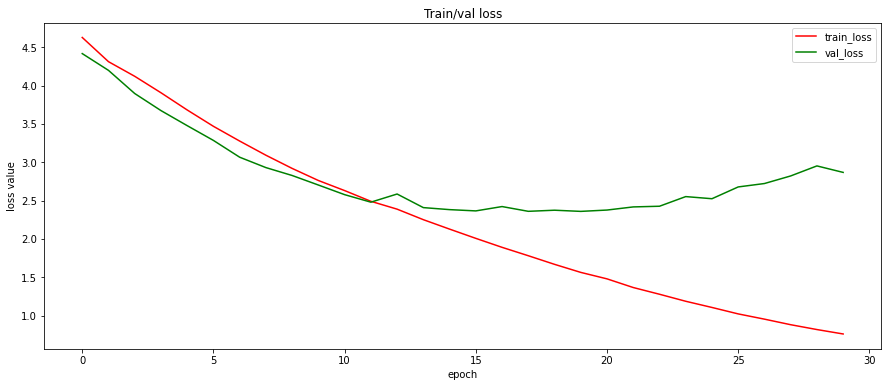

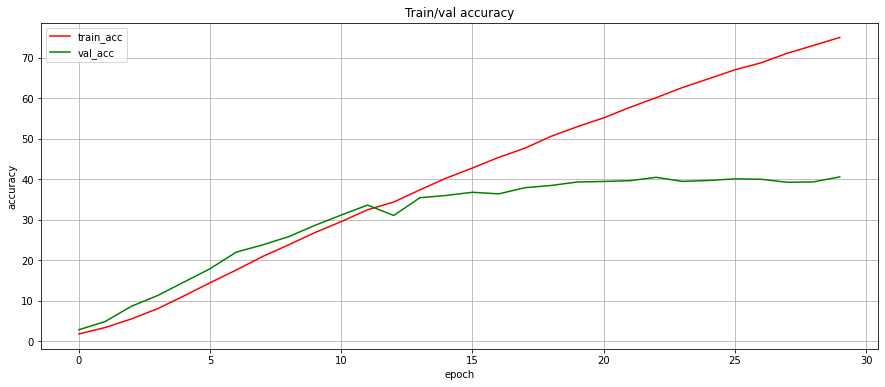

In [65]:
plot(n_epochs, train_losses, val_losses, train_accuracies, val_accuracies)


## Task 4. Ablations
Try to find the best performing model by tuning the model design and hyper-parameters on the validation set. Perform ablation experiments to illustrate the effect of the most important hyper-parameters. Some examples of ablations: training parameters (e.g., optimizer, learning rates, batch size), network architecture (e.g., number of layers, number of units, activation function, normalization layers), model regularization (e.g., data augmentation, dropout, weight decay, early stopping), test-time augmentation, etc...  <br>**Perform at least 5 ablations and report the performance of each on the validation set.**

### Ablation 1: data augmentation (random horizontal flip + random vary brightness and contrast)
- val_acc = 43%

In [7]:
from torchvision.transforms import RandomHorizontalFlip, ColorJitter
train_transform = Compose([Resize((64, 64)),
                        RandomHorizontalFlip(),
                        ColorJitter(0.3,0.7),
                        ToTensor(), # Converts to Tensor, scales to [0, 1] float (from [0, 255] int)
                        Normalize(mean=(0.5, 0.5, 0.5,), std=(0.5, 0.5, 0.5)), # scales to [-1.0, 1.0]
                        ])

train_set_data_augmented = ImageNetLimited(train_dir,transform=train_transform)
train_data_augmented_dataloader = DataLoader(train_set_data_augmented, batch_size=batch_size, shuffle=True, num_workers=8,pin_memory=True)


Epoch 1/30: train_loss: 4.6860, train_accuracy: 1.4450, val_loss: 4.4612, val_accuracy: 2.4117



Epoch 2/30: train_loss: 4.4284, train_accuracy: 2.6250, val_loss: 4.3918, val_accuracy: 3.4165



Epoch 3/30: train_loss: 4.3220, train_accuracy: 3.3817, val_loss: 4.1411, val_accuracy: 5.3793



Epoch 4/30: train_loss: 4.1865, train_accuracy: 4.8467, val_loss: 3.9575, val_accuracy: 7.7273



Epoch 5/30: train_loss: 4.0111, train_accuracy: 7.2850, val_loss: 3.7929, val_accuracy: 10.3132



Epoch 6/30: train_loss: 3.8352, train_accuracy: 9.4133, val_loss: 3.7301, val_accuracy: 10.9663



Epoch 7/30: train_loss: 3.6704, train_accuracy: 11.6417, val_loss: 3.3919, val_accuracy: 16.3557



Epoch 8/30: train_loss: 3.5129, train_accuracy: 13.4300, val_loss: 3.2683, val_accuracy: 17.8262



Epoch 9/30: train_loss: 3.3691, train_accuracy: 15.9950, val_loss: 3.1319, val_accuracy: 20.2914



Epoch 10/30: train_loss: 3.2325, train_accuracy: 18.3117, val_loss: 3.0014, val_accuracy: 22.5356



Epoch 11/30: train_loss: 3.1078, train_accuracy: 20.4950, val_loss: 2.8245, val_accuracy: 25.9956



Epoch 12/30: train_loss: 2.9895, train_accuracy: 22.7400, val_loss: 2.8503, val_accuracy: 25.6875



Epoch 13/30: train_loss: 2.8907, train_accuracy: 24.5183, val_loss: 2.6787, val_accuracy: 28.6853



Epoch 14/30: train_loss: 2.7903, train_accuracy: 26.6250, val_loss: 2.5775, val_accuracy: 30.8692



Epoch 15/30: train_loss: 2.6896, train_accuracy: 28.7950, val_loss: 2.5712, val_accuracy: 31.0099



Epoch 16/30: train_loss: 2.6010, train_accuracy: 30.3600, val_loss: 2.5683, val_accuracy: 31.6195



Epoch 17/30: train_loss: 2.5176, train_accuracy: 32.2333, val_loss: 2.5612, val_accuracy: 32.7617



Epoch 18/30: train_loss: 2.4344, train_accuracy: 33.8517, val_loss: 2.3695, val_accuracy: 35.4413



Epoch 19/30: train_loss: 2.3707, train_accuracy: 35.0100, val_loss: 2.3636, val_accuracy: 36.3189



Epoch 20/30: train_loss: 2.3005, train_accuracy: 36.6733, val_loss: 2.2747, val_accuracy: 37.8396



Epoch 21/30: train_loss: 2.2341, train_accuracy: 38.0183, val_loss: 2.2681, val_accuracy: 38.3989



Epoch 22/30: train_loss: 2.1661, train_accuracy: 39.5083, val_loss: 2.2308, val_accuracy: 39.5813



Epoch 23/30: train_loss: 2.0955, train_accuracy: 41.0483, val_loss: 2.2044, val_accuracy: 39.8627



Epoch 24/30: train_loss: 2.0416, train_accuracy: 42.0900, val_loss: 2.1924, val_accuracy: 40.0770



Epoch 25/30: train_loss: 1.9751, train_accuracy: 43.8567, val_loss: 2.1487, val_accuracy: 41.6245



Epoch 26/30: train_loss: 1.9281, train_accuracy: 44.6783, val_loss: 2.1846, val_accuracy: 40.8943



Epoch 27/30: train_loss: 1.8755, train_accuracy: 46.2217, val_loss: 2.1458, val_accuracy: 42.1035



Epoch 28/30: train_loss: 1.8232, train_accuracy: 47.5367, val_loss: 2.1154, val_accuracy: 42.5121



Epoch 29/30: train_loss: 1.7601, train_accuracy: 48.6700, val_loss: 2.1301, val_accuracy: 42.8504



Epoch 30/30: train_loss: 1.7106, train_accuracy: 49.6983, val_loss: 2.1026, val_accuracy: 43.2155


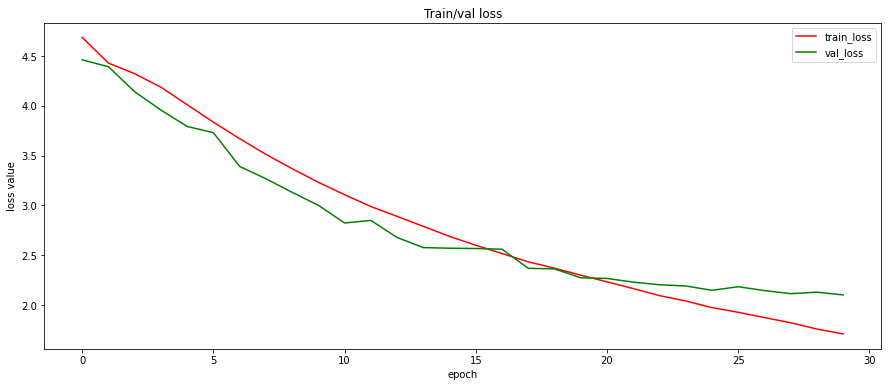

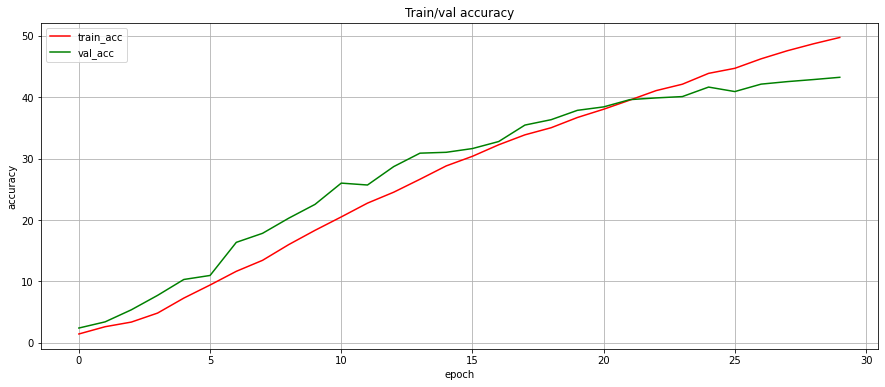

In [7]:

model_conv_data_augmented = ConvNet()
model_conv_data_augmented = model_conv_data_augmented.to(device)
optimizer_data_augmented = torch.optim.Adam(model_conv_data_augmented.parameters(), lr=learning_rate)

train_data_augmented_losses, val_data_augmented_losses, train_data_augmented_accuracies, val_data_augmented_accuracies = train(model_conv_data_augmented, train_data_augmented_dataloader, val_dataloader, optimizer_data_augmented, n_epochs=n_epochs, loss_function=loss_fn)
plot(n_epochs, train_data_augmented_losses, val_data_augmented_losses, train_data_augmented_accuracies, val_data_augmented_accuracies)

### Ablation 2: vary number of neurons on linear layers
- 1024 neurons: val_acc ~= 39%
- 512 neurons: val_acc ~= 25%
- 4096 neurons: val_acc ~= 39%

In [0]:
class ConvNetVaryLinearNeurons(nn.Module):
    
    def __init__(self,linear_neurons,num_classes=100):
        super(ConvNetVaryLinearNeurons, self).__init__()
        #vgg19 architecture without the last 512 conv layers and without the intermediate linear layer
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layer = nn.Sequential(
            nn.Linear(256 * 7 * 7, linear_neurons),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(linear_neurons, num_classes)
        )

        
    def forward(self, input):
        output = self.conv_layers(input) 
        output = nn.AdaptiveAvgPool2d((7, 7))(output)
        output = torch.flatten(output, 1)
        output = self.linear_layer(output)
        return output

def train_plot_n_linear_neurons(n):
    model_conv_n_linear_neurons = ConvNetVaryLinearNeurons(n)
    model_conv_n_linear_neurons = model_conv_n_linear_neurons.to(device)
    optimizer_n_neurons = torch.optim.Adam(model_conv_n_linear_neurons.parameters(), lr=learning_rate)

    train_losses_n_neurons, val_losses_n_neurons, train_accuracies_n_neurons, val_accuracies_n_neurons = train(model_conv_n_linear_neurons, train_dataloader, val_dataloader, optimizer_n_neurons, n_epochs=n_epochs, loss_function=loss_fn)
    plot(n_epochs, train_losses_n_neurons, val_losses_n_neurons, train_accuracies_n_neurons, val_accuracies_n_neurons)

    return model_conv_n_linear_neurons



Epoch 1/30: train_loss: 4.5429, train_accuracy: 2.2817, val_loss: 4.2444, val_accuracy: 4.0764



Epoch 2/30: train_loss: 4.2480, train_accuracy: 4.3700, val_loss: 4.0378, val_accuracy: 6.4780



Epoch 3/30: train_loss: 4.0351, train_accuracy: 6.5933, val_loss: 3.7897, val_accuracy: 10.0352



Epoch 4/30: train_loss: 3.8483, train_accuracy: 8.9150, val_loss: 3.5730, val_accuracy: 13.2273



Epoch 5/30: train_loss: 3.6835, train_accuracy: 11.0500, val_loss: 3.3885, val_accuracy: 15.5451



Epoch 6/30: train_loss: 3.5235, train_accuracy: 13.4783, val_loss: 3.3732, val_accuracy: 16.3825



Epoch 7/30: train_loss: 3.3706, train_accuracy: 15.6900, val_loss: 3.1668, val_accuracy: 19.4574



Epoch 8/30: train_loss: 3.2231, train_accuracy: 18.0600, val_loss: 2.9784, val_accuracy: 23.3294



Epoch 9/30: train_loss: 3.0813, train_accuracy: 20.4917, val_loss: 2.9007, val_accuracy: 24.1836



Epoch 10/30: train_loss: 2.9547, train_accuracy: 22.5217, val_loss: 2.7866, val_accuracy: 26.5014



Epoch 11/30: train_loss: 2.8253, train_accuracy: 25.1517, val_loss: 2.6981, val_accuracy: 28.5279



Epoch 12/30: train_loss: 2.7051, train_accuracy: 27.4267, val_loss: 2.6335, val_accuracy: 29.9079



Epoch 13/30: train_loss: 2.5794, train_accuracy: 29.8750, val_loss: 2.5960, val_accuracy: 31.0601



Epoch 14/30: train_loss: 2.4646, train_accuracy: 32.1650, val_loss: 2.5064, val_accuracy: 33.0464



Epoch 15/30: train_loss: 2.3555, train_accuracy: 34.5233, val_loss: 2.4483, val_accuracy: 34.4733



Epoch 16/30: train_loss: 2.2475, train_accuracy: 36.7800, val_loss: 2.4129, val_accuracy: 35.1130



Epoch 17/30: train_loss: 2.1491, train_accuracy: 38.7133, val_loss: 2.4194, val_accuracy: 35.2705



Epoch 18/30: train_loss: 2.0385, train_accuracy: 41.0800, val_loss: 2.4300, val_accuracy: 35.7428



Epoch 19/30: train_loss: 1.9340, train_accuracy: 43.4283, val_loss: 2.3741, val_accuracy: 36.8146



Epoch 20/30: train_loss: 1.8343, train_accuracy: 45.4800, val_loss: 2.5164, val_accuracy: 35.8164



Epoch 21/30: train_loss: 1.7408, train_accuracy: 47.6133, val_loss: 2.4336, val_accuracy: 37.9099



Epoch 22/30: train_loss: 1.6421, train_accuracy: 50.0717, val_loss: 2.4811, val_accuracy: 36.8012



Epoch 23/30: train_loss: 1.5516, train_accuracy: 52.0533, val_loss: 2.5245, val_accuracy: 37.9400



Epoch 24/30: train_loss: 1.4696, train_accuracy: 54.0700, val_loss: 2.4398, val_accuracy: 38.6233



Epoch 25/30: train_loss: 1.3944, train_accuracy: 56.0917, val_loss: 2.4622, val_accuracy: 39.4574



Epoch 26/30: train_loss: 1.2975, train_accuracy: 58.2700, val_loss: 2.5947, val_accuracy: 39.0688



Epoch 27/30: train_loss: 1.2211, train_accuracy: 60.3717, val_loss: 2.6280, val_accuracy: 38.9148



Epoch 28/30: train_loss: 1.1526, train_accuracy: 62.1867, val_loss: 2.7774, val_accuracy: 38.6267



Epoch 29/30: train_loss: 1.0907, train_accuracy: 64.0717, val_loss: 2.8108, val_accuracy: 37.9099



Epoch 30/30: train_loss: 1.0201, train_accuracy: 66.2033, val_loss: 2.8711, val_accuracy: 39.4842


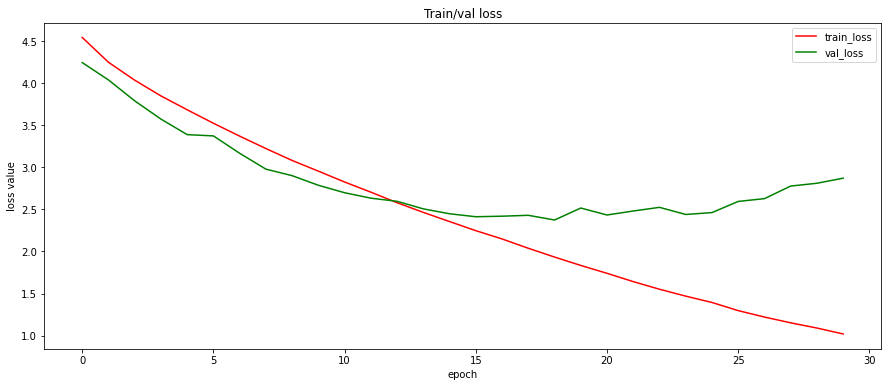

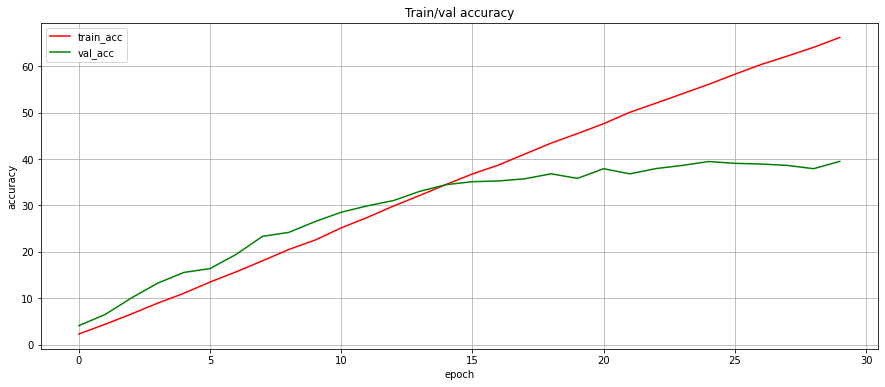

In [11]:
model_conv_1024_linear_neurons = train_plot_n_linear_neurons(1024)


Epoch 1/30: train_loss: 4.6211, train_accuracy: 1.1617, val_loss: 4.5796, val_accuracy: 1.6379



Epoch 2/30: train_loss: 4.5751, train_accuracy: 1.2767, val_loss: 4.5333, val_accuracy: 1.8322



Epoch 3/30: train_loss: 4.5612, train_accuracy: 1.3067, val_loss: 4.5165, val_accuracy: 1.7016



Epoch 4/30: train_loss: 4.5547, train_accuracy: 1.2967, val_loss: 4.5145, val_accuracy: 1.9293



Epoch 5/30: train_loss: 4.5493, train_accuracy: 1.3450, val_loss: 4.4824, val_accuracy: 2.1236



Epoch 6/30: train_loss: 4.5400, train_accuracy: 1.3667, val_loss: 4.4942, val_accuracy: 2.0164



Epoch 7/30: train_loss: 4.5311, train_accuracy: 1.4750, val_loss: 4.4685, val_accuracy: 2.0767



Epoch 8/30: train_loss: 4.5154, train_accuracy: 1.5650, val_loss: 4.3752, val_accuracy: 2.7131



Epoch 9/30: train_loss: 4.4135, train_accuracy: 2.3100, val_loss: 4.2925, val_accuracy: 3.6175



Epoch 10/30: train_loss: 4.2921, train_accuracy: 3.2500, val_loss: 4.0890, val_accuracy: 5.2989



Epoch 11/30: train_loss: 4.1871, train_accuracy: 4.1100, val_loss: 4.0160, val_accuracy: 7.0641



Epoch 12/30: train_loss: 4.1164, train_accuracy: 4.7100, val_loss: 3.9105, val_accuracy: 7.8245



Epoch 13/30: train_loss: 4.0583, train_accuracy: 5.2400, val_loss: 3.8238, val_accuracy: 9.2882



Epoch 14/30: train_loss: 4.0043, train_accuracy: 5.7317, val_loss: 3.7773, val_accuracy: 9.6600



Epoch 15/30: train_loss: 3.9418, train_accuracy: 6.1233, val_loss: 3.6614, val_accuracy: 10.5041



Epoch 16/30: train_loss: 3.8540, train_accuracy: 7.2400, val_loss: 3.5955, val_accuracy: 11.7501



Epoch 17/30: train_loss: 3.7614, train_accuracy: 8.3417, val_loss: 3.5647, val_accuracy: 11.7300



Epoch 18/30: train_loss: 3.7057, train_accuracy: 9.1700, val_loss: 3.4823, val_accuracy: 13.8369



Epoch 19/30: train_loss: 3.6533, train_accuracy: 9.7433, val_loss: 3.4068, val_accuracy: 14.9355



Epoch 20/30: train_loss: 3.5912, train_accuracy: 10.6233, val_loss: 3.3082, val_accuracy: 16.8715



Epoch 21/30: train_loss: 3.5386, train_accuracy: 11.2933, val_loss: 3.2932, val_accuracy: 16.7141



Epoch 22/30: train_loss: 3.4870, train_accuracy: 12.1350, val_loss: 3.2654, val_accuracy: 17.1027



Epoch 23/30: train_loss: 3.4330, train_accuracy: 12.8733, val_loss: 3.2619, val_accuracy: 17.6118



Epoch 24/30: train_loss: 3.3716, train_accuracy: 13.8800, val_loss: 3.1574, val_accuracy: 19.4607



Epoch 25/30: train_loss: 3.2809, train_accuracy: 15.4267, val_loss: 3.0939, val_accuracy: 20.0435



Epoch 26/30: train_loss: 3.1854, train_accuracy: 16.9733, val_loss: 2.9953, val_accuracy: 22.8739



Epoch 27/30: train_loss: 3.1115, train_accuracy: 18.2333, val_loss: 2.9239, val_accuracy: 23.5203



Epoch 28/30: train_loss: 3.0548, train_accuracy: 19.0450, val_loss: 2.9047, val_accuracy: 24.2371



Epoch 29/30: train_loss: 3.0006, train_accuracy: 19.7617, val_loss: 2.8623, val_accuracy: 24.6692



Epoch 30/30: train_loss: 2.9434, train_accuracy: 20.6167, val_loss: 2.8351, val_accuracy: 25.2822


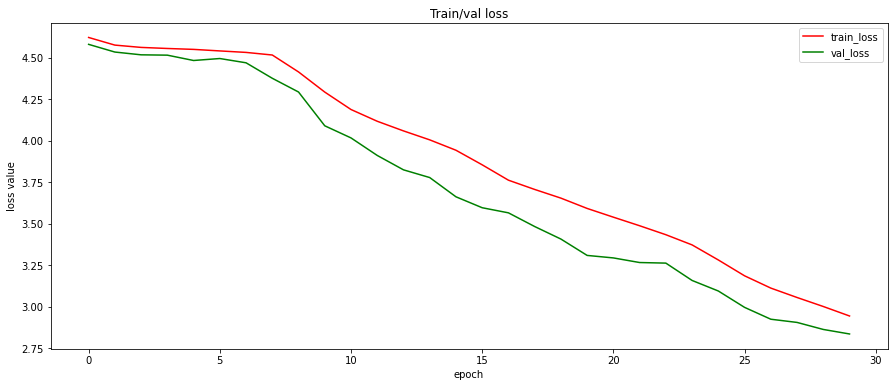

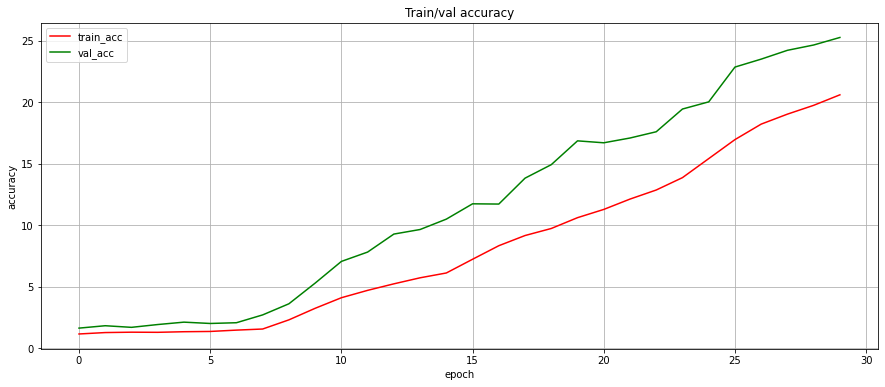

In [12]:
model_conv_512_linear_neurons = train_plot_n_linear_neurons(512)


Epoch 1/30: train_loss: 4.6903, train_accuracy: 1.8883, val_loss: 4.3254, val_accuracy: 3.1954



Epoch 2/30: train_loss: 4.3122, train_accuracy: 3.9617, val_loss: 4.1181, val_accuracy: 5.7176



Epoch 3/30: train_loss: 4.0654, train_accuracy: 6.4233, val_loss: 3.7944, val_accuracy: 9.7103



Epoch 4/30: train_loss: 3.7554, train_accuracy: 10.6850, val_loss: 3.5325, val_accuracy: 14.0412



Epoch 5/30: train_loss: 3.4996, train_accuracy: 14.4000, val_loss: 3.3610, val_accuracy: 16.2753



Epoch 6/30: train_loss: 3.2724, train_accuracy: 18.3467, val_loss: 3.1188, val_accuracy: 20.4254



Epoch 7/30: train_loss: 3.0461, train_accuracy: 22.2850, val_loss: 3.1136, val_accuracy: 22.3447



Epoch 8/30: train_loss: 2.8582, train_accuracy: 25.4733, val_loss: 2.8723, val_accuracy: 26.2837



Epoch 9/30: train_loss: 2.6586, train_accuracy: 29.7283, val_loss: 2.6627, val_accuracy: 29.8945



Epoch 10/30: train_loss: 2.5007, train_accuracy: 33.0317, val_loss: 2.5570, val_accuracy: 32.4736



Epoch 11/30: train_loss: 2.3319, train_accuracy: 36.6467, val_loss: 2.5195, val_accuracy: 33.8503



Epoch 12/30: train_loss: 2.1734, train_accuracy: 40.1283, val_loss: 2.3801, val_accuracy: 36.3557



Epoch 13/30: train_loss: 2.0283, train_accuracy: 43.3100, val_loss: 2.4219, val_accuracy: 35.7093



Epoch 14/30: train_loss: 1.8786, train_accuracy: 46.9400, val_loss: 2.4819, val_accuracy: 35.9236



Epoch 15/30: train_loss: 1.8022, train_accuracy: 48.7367, val_loss: 2.3570, val_accuracy: 38.1511



Epoch 16/30: train_loss: 1.5895, train_accuracy: 53.6267, val_loss: 2.3782, val_accuracy: 38.0707



Epoch 17/30: train_loss: 1.4458, train_accuracy: 57.2283, val_loss: 2.3649, val_accuracy: 39.1928



Epoch 18/30: train_loss: 1.3096, train_accuracy: 60.7517, val_loss: 2.4402, val_accuracy: 38.7607



Epoch 19/30: train_loss: 1.1787, train_accuracy: 64.1800, val_loss: 2.4699, val_accuracy: 39.4641



Epoch 20/30: train_loss: 1.0532, train_accuracy: 67.4633, val_loss: 2.5937, val_accuracy: 39.1827



Epoch 21/30: train_loss: 0.9432, train_accuracy: 70.7883, val_loss: 2.6986, val_accuracy: 38.4492



Epoch 22/30: train_loss: 0.8445, train_accuracy: 73.3567, val_loss: 2.7543, val_accuracy: 39.0755



Epoch 23/30: train_loss: 0.7677, train_accuracy: 75.5550, val_loss: 2.7598, val_accuracy: 38.8947



Epoch 24/30: train_loss: 0.6900, train_accuracy: 77.9517, val_loss: 2.9189, val_accuracy: 37.4678



Epoch 25/30: train_loss: 0.7063, train_accuracy: 77.6800, val_loss: 2.9337, val_accuracy: 38.4793



Epoch 26/30: train_loss: 0.5879, train_accuracy: 81.0733, val_loss: 3.0352, val_accuracy: 38.6568



Epoch 27/30: train_loss: 0.5328, train_accuracy: 82.9150, val_loss: 3.0834, val_accuracy: 38.7942



Epoch 28/30: train_loss: 0.4937, train_accuracy: 83.9667, val_loss: 3.2369, val_accuracy: 38.8612



Epoch 29/30: train_loss: 0.4740, train_accuracy: 84.6067, val_loss: 3.1238, val_accuracy: 39.1459



Epoch 30/30: train_loss: 0.4332, train_accuracy: 86.0250, val_loss: 3.2837, val_accuracy: 38.9951


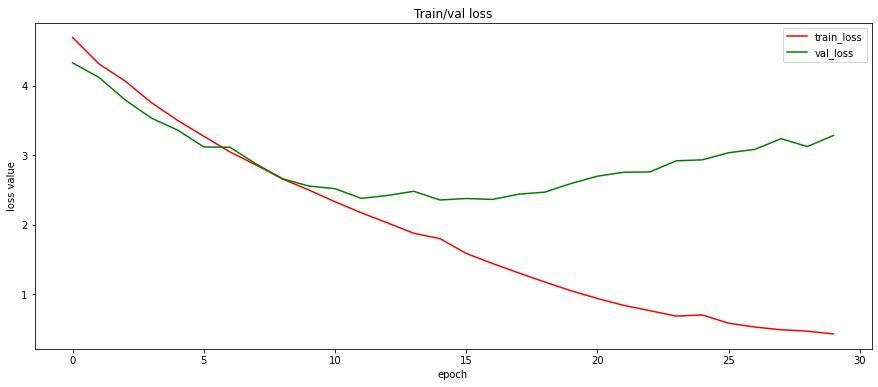

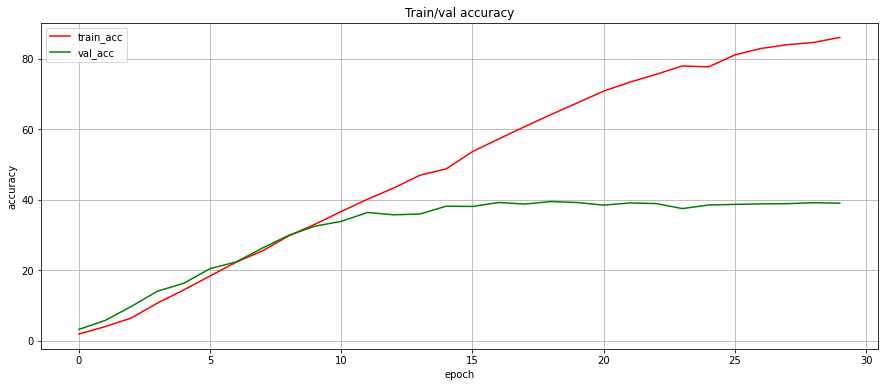

In [13]:
model_conv_4096_linear_neurons = train_plot_n_linear_neurons(4096)

### Ablation 3: vary optimizer
- Use weight decay with Adam: val_acc ~= 32%
- Use SGD with nesterov momentum: val_acc ~= 39%


Epoch 1/30: train_loss: 4.6088, train_accuracy: 2.2333, val_loss: 4.3894, val_accuracy: 3.0380



Epoch 2/30: train_loss: 4.1968, train_accuracy: 5.0500, val_loss: 3.9978, val_accuracy: 6.9804



Epoch 3/30: train_loss: 3.9180, train_accuracy: 8.3633, val_loss: 3.8552, val_accuracy: 9.1442



Epoch 4/30: train_loss: 3.6623, train_accuracy: 11.5750, val_loss: 3.5227, val_accuracy: 14.0211



Epoch 5/30: train_loss: 3.4531, train_accuracy: 15.0667, val_loss: 3.3529, val_accuracy: 16.6739



Epoch 6/30: train_loss: 3.2782, train_accuracy: 17.6467, val_loss: 3.2583, val_accuracy: 18.5564



Epoch 7/30: train_loss: 3.1368, train_accuracy: 20.0717, val_loss: 3.0894, val_accuracy: 20.9948



Epoch 8/30: train_loss: 3.0214, train_accuracy: 22.0217, val_loss: 2.8900, val_accuracy: 24.7965



Epoch 9/30: train_loss: 2.9192, train_accuracy: 23.9100, val_loss: 2.9280, val_accuracy: 23.7515



Epoch 10/30: train_loss: 2.8452, train_accuracy: 25.3883, val_loss: 2.8693, val_accuracy: 25.0846



Epoch 11/30: train_loss: 2.7742, train_accuracy: 26.7383, val_loss: 2.7754, val_accuracy: 27.6135



Epoch 12/30: train_loss: 2.7134, train_accuracy: 27.8600, val_loss: 2.7314, val_accuracy: 27.9886



Epoch 13/30: train_loss: 2.6680, train_accuracy: 28.7017, val_loss: 2.7130, val_accuracy: 28.6485



Epoch 14/30: train_loss: 2.6137, train_accuracy: 30.0333, val_loss: 2.6640, val_accuracy: 29.8141



Epoch 15/30: train_loss: 2.5793, train_accuracy: 30.5300, val_loss: 2.6499, val_accuracy: 29.8610



Epoch 16/30: train_loss: 2.5459, train_accuracy: 31.2617, val_loss: 2.7772, val_accuracy: 27.6034



Epoch 17/30: train_loss: 2.5145, train_accuracy: 31.9783, val_loss: 2.6468, val_accuracy: 30.0519



Epoch 18/30: train_loss: 2.4792, train_accuracy: 32.5033, val_loss: 2.9258, val_accuracy: 25.3592



Epoch 19/30: train_loss: 2.4521, train_accuracy: 33.0883, val_loss: 2.7119, val_accuracy: 28.8260



Epoch 20/30: train_loss: 2.4209, train_accuracy: 33.7917, val_loss: 2.5668, val_accuracy: 30.9697



Epoch 21/30: train_loss: 2.4037, train_accuracy: 34.0450, val_loss: 2.6106, val_accuracy: 30.7721



Epoch 22/30: train_loss: 2.3689, train_accuracy: 34.8633, val_loss: 2.7917, val_accuracy: 28.0456



Epoch 23/30: train_loss: 2.3477, train_accuracy: 35.5067, val_loss: 2.7181, val_accuracy: 28.8997



Epoch 24/30: train_loss: 2.3312, train_accuracy: 35.6033, val_loss: 2.6544, val_accuracy: 29.4524



Epoch 25/30: train_loss: 2.3117, train_accuracy: 35.9367, val_loss: 2.5750, val_accuracy: 31.3817



Epoch 26/30: train_loss: 2.2971, train_accuracy: 36.2500, val_loss: 2.5703, val_accuracy: 31.5693



Epoch 27/30: train_loss: 2.2745, train_accuracy: 36.5850, val_loss: 2.5517, val_accuracy: 32.9024



Epoch 28/30: train_loss: 2.2588, train_accuracy: 37.3433, val_loss: 2.5123, val_accuracy: 32.3296



Epoch 29/30: train_loss: 2.2428, train_accuracy: 37.4200, val_loss: 2.5802, val_accuracy: 32.0884



Epoch 30/30: train_loss: 2.2284, train_accuracy: 37.7383, val_loss: 2.5676, val_accuracy: 31.5425


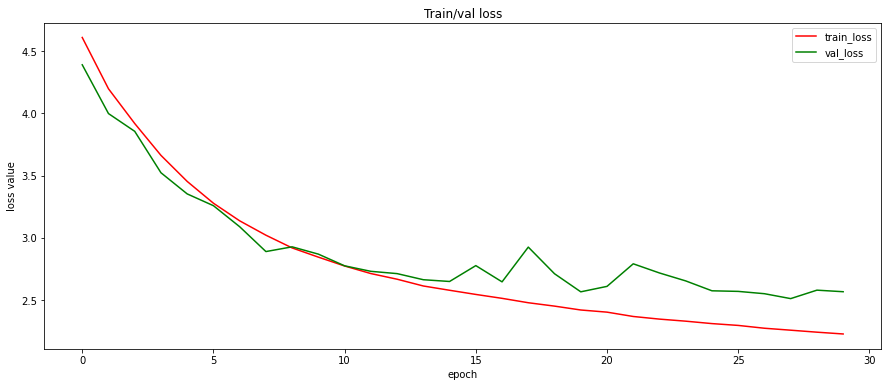

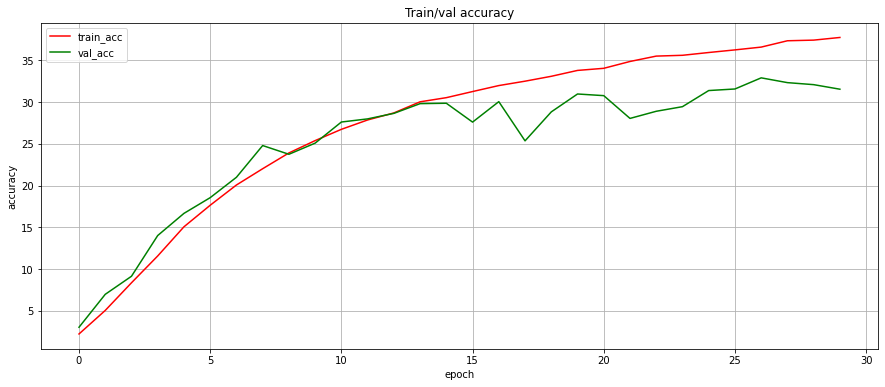

In [16]:
model_conv_weight_decay = ConvNet()
model_conv_weight_decay = model_conv_weight_decay.to(device)

optimizer_weight_decay = torch.optim.Adam(model_conv_weight_decay.parameters(), lr=learning_rate,weight_decay=0.001)

train_losses_weight_decay, val_losses_weight_decay, train_accuracies_weight_decay, val_accuracies_weight_decay = train(model_conv_weight_decay, train_dataloader, val_dataloader, optimizer_weight_decay, n_epochs=n_epochs, loss_function=loss_fn)
plot(n_epochs,train_losses_weight_decay, val_losses_weight_decay, train_accuracies_weight_decay, val_accuracies_weight_decay)


Epoch 1/30: train_loss: 4.0467, train_accuracy: 7.4567, val_loss: 3.6212, val_accuracy: 13.3847



Epoch 2/30: train_loss: 3.4792, train_accuracy: 15.3633, val_loss: 3.3901, val_accuracy: 16.8180



Epoch 3/30: train_loss: 3.1687, train_accuracy: 20.5517, val_loss: 3.2039, val_accuracy: 20.8072



Epoch 4/30: train_loss: 2.9127, train_accuracy: 25.1433, val_loss: 2.8757, val_accuracy: 26.3473



Epoch 5/30: train_loss: 2.6975, train_accuracy: 29.4050, val_loss: 2.9712, val_accuracy: 25.7846



Epoch 6/30: train_loss: 2.5084, train_accuracy: 33.2933, val_loss: 2.8187, val_accuracy: 28.3236



Epoch 7/30: train_loss: 2.3487, train_accuracy: 36.6217, val_loss: 2.5967, val_accuracy: 32.5741



Epoch 8/30: train_loss: 2.2052, train_accuracy: 39.8267, val_loss: 2.5127, val_accuracy: 33.7933



Epoch 9/30: train_loss: 2.0727, train_accuracy: 42.6083, val_loss: 2.5324, val_accuracy: 34.1182



Epoch 10/30: train_loss: 1.9466, train_accuracy: 45.7500, val_loss: 2.6654, val_accuracy: 33.0196



Epoch 11/30: train_loss: 1.8253, train_accuracy: 48.4300, val_loss: 2.4282, val_accuracy: 36.3423



Epoch 12/30: train_loss: 1.7135, train_accuracy: 51.2350, val_loss: 2.4492, val_accuracy: 36.5600



Epoch 13/30: train_loss: 1.6046, train_accuracy: 53.8733, val_loss: 2.4992, val_accuracy: 36.1012



Epoch 14/30: train_loss: 1.4892, train_accuracy: 56.7733, val_loss: 2.4290, val_accuracy: 36.9586



Epoch 15/30: train_loss: 1.3901, train_accuracy: 59.2550, val_loss: 2.6505, val_accuracy: 36.1815



Epoch 16/30: train_loss: 1.2860, train_accuracy: 62.0783, val_loss: 2.4183, val_accuracy: 38.7104



Epoch 17/30: train_loss: 1.1797, train_accuracy: 64.6650, val_loss: 2.4241, val_accuracy: 39.0923



Epoch 18/30: train_loss: 1.0833, train_accuracy: 67.3400, val_loss: 2.5735, val_accuracy: 38.3554



Epoch 19/30: train_loss: 0.9866, train_accuracy: 70.0533, val_loss: 2.6716, val_accuracy: 37.3438



Epoch 20/30: train_loss: 0.8927, train_accuracy: 72.7017, val_loss: 2.7196, val_accuracy: 37.8128



Epoch 21/30: train_loss: 0.8045, train_accuracy: 75.3400, val_loss: 2.8159, val_accuracy: 37.5984



Epoch 22/30: train_loss: 0.7245, train_accuracy: 77.5767, val_loss: 3.1531, val_accuracy: 35.1968



Epoch 23/30: train_loss: 0.6420, train_accuracy: 80.0783, val_loss: 2.7207, val_accuracy: 38.3420



Epoch 24/30: train_loss: 0.5749, train_accuracy: 82.0583, val_loss: 2.8238, val_accuracy: 38.6099



Epoch 25/30: train_loss: 0.5060, train_accuracy: 84.2167, val_loss: 3.1037, val_accuracy: 36.3691



Epoch 26/30: train_loss: 0.4547, train_accuracy: 85.7617, val_loss: 2.9374, val_accuracy: 39.7588



Epoch 27/30: train_loss: 0.4003, train_accuracy: 87.6133, val_loss: 3.0263, val_accuracy: 39.1358



Epoch 28/30: train_loss: 0.3578, train_accuracy: 88.8617, val_loss: 3.0879, val_accuracy: 38.2683



Epoch 29/30: train_loss: 0.3150, train_accuracy: 90.1450, val_loss: 2.9619, val_accuracy: 39.5244



Epoch 30/30: train_loss: 0.2815, train_accuracy: 91.4750, val_loss: 3.3137, val_accuracy: 38.2449


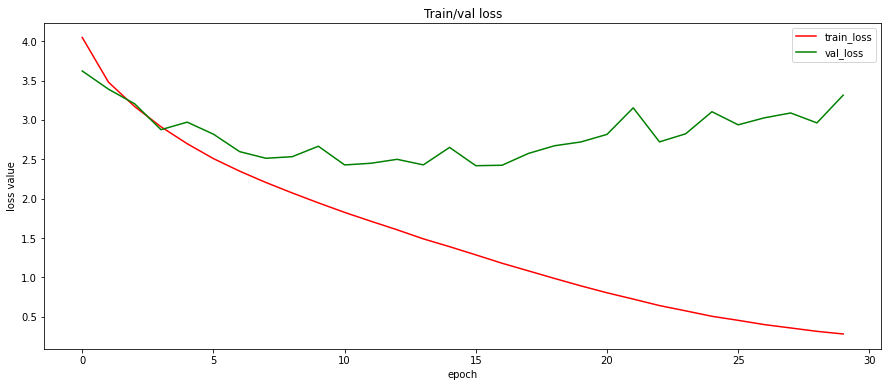

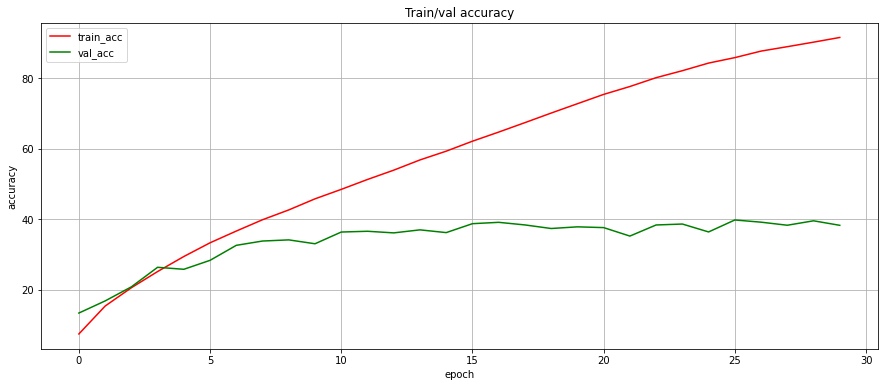

In [29]:
model_conv_sgd_momentum = ConvNet()
model_conv_sgd_momentum =model_conv_sgd_momentum.to(device)
sgd_momentum_optimizer=torch.optim.SGD(model_conv_sgd_momentum.parameters(),lr=learning_rate,momentum=0.9,nesterov=True)

train_losses_sgd_momentum, val_losses_sgd_momentum, train_accuracies_sgd_momentum, val_accuracies_sgd_momentum = train(model_conv_sgd_momentum, train_dataloader, val_dataloader, sgd_momentum_optimizer, n_epochs=n_epochs, loss_function=loss_fn)
plot(n_epochs,train_losses_sgd_momentum, val_losses_sgd_momentum, train_accuracies_sgd_momentum, val_accuracies_sgd_momentum)

### Ablation 4: vary learning rate
- lr = 0.0001: val_acc ~= 38%
- lr = 0.0005: val_acc ~= 40%
- lr = 0.01 had a val_acc around 1%, I removed it from the notebook

In [0]:
def train_plot_learning_rate(learning_rate):
    model_conv_lr = ConvNet()
    model_conv_lr = model_conv_lr.to(device)

    optimizer = torch.optim.Adam(model_conv_lr.parameters(), lr=learning_rate)

    train_losses_lr, val_losses_lr, train_accuracies_lr, val_accuracies_lr = train(model_conv_lr, train_dataloader, val_dataloader, optimizer, n_epochs=n_epochs, loss_function=loss_fn)
    plot(n_epochs, train_losses_lr, val_losses_lr, train_accuracies_lr, val_accuracies_lr)

    return model_conv_lr


Epoch 1/30: train_loss: 4.0484, train_accuracy: 7.6650, val_loss: 3.6880, val_accuracy: 12.5306



Epoch 2/30: train_loss: 3.4704, train_accuracy: 15.3300, val_loss: 3.3495, val_accuracy: 17.7357



Epoch 3/30: train_loss: 3.1415, train_accuracy: 21.0300, val_loss: 2.9541, val_accuracy: 24.4649



Epoch 4/30: train_loss: 2.8856, train_accuracy: 25.7167, val_loss: 2.9401, val_accuracy: 25.0578



Epoch 5/30: train_loss: 2.6771, train_accuracy: 29.4300, val_loss: 2.8045, val_accuracy: 28.3973



Epoch 6/30: train_loss: 2.5067, train_accuracy: 33.0583, val_loss: 2.5679, val_accuracy: 32.3564



Epoch 7/30: train_loss: 2.3612, train_accuracy: 35.8483, val_loss: 2.5588, val_accuracy: 32.2860



Epoch 8/30: train_loss: 2.2196, train_accuracy: 39.1833, val_loss: 2.5425, val_accuracy: 33.3344



Epoch 9/30: train_loss: 2.0955, train_accuracy: 41.4217, val_loss: 2.5004, val_accuracy: 34.5805



Epoch 10/30: train_loss: 1.9774, train_accuracy: 44.0917, val_loss: 2.4582, val_accuracy: 36.1614



Epoch 11/30: train_loss: 1.8683, train_accuracy: 46.4417, val_loss: 2.3631, val_accuracy: 37.6218



Epoch 12/30: train_loss: 1.7582, train_accuracy: 49.0800, val_loss: 2.4151, val_accuracy: 37.2467



Epoch 13/30: train_loss: 1.6547, train_accuracy: 51.3717, val_loss: 2.5192, val_accuracy: 35.7059



Epoch 14/30: train_loss: 1.5604, train_accuracy: 53.4883, val_loss: 2.3913, val_accuracy: 38.3587



Epoch 15/30: train_loss: 1.4643, train_accuracy: 55.7967, val_loss: 2.4543, val_accuracy: 37.8831



Epoch 16/30: train_loss: 1.3617, train_accuracy: 58.4833, val_loss: 2.6164, val_accuracy: 36.4864



Epoch 17/30: train_loss: 1.2678, train_accuracy: 60.8817, val_loss: 2.8227, val_accuracy: 35.4078



Epoch 18/30: train_loss: 1.1815, train_accuracy: 62.8567, val_loss: 2.5100, val_accuracy: 37.3840



Epoch 19/30: train_loss: 1.0987, train_accuracy: 65.3517, val_loss: 2.7516, val_accuracy: 37.6989



Epoch 20/30: train_loss: 1.0246, train_accuracy: 67.2600, val_loss: 2.7861, val_accuracy: 37.6989



Epoch 21/30: train_loss: 0.9462, train_accuracy: 69.5700, val_loss: 2.6307, val_accuracy: 38.6702



Epoch 22/30: train_loss: 0.8669, train_accuracy: 71.7133, val_loss: 3.1144, val_accuracy: 36.7409



Epoch 23/30: train_loss: 0.8102, train_accuracy: 73.4900, val_loss: 3.0192, val_accuracy: 36.8715



Epoch 24/30: train_loss: 0.7544, train_accuracy: 75.1167, val_loss: 3.2557, val_accuracy: 35.4781



Epoch 25/30: train_loss: 0.7026, train_accuracy: 76.4783, val_loss: 3.1333, val_accuracy: 36.7912



Epoch 26/30: train_loss: 0.6559, train_accuracy: 78.1417, val_loss: 3.1613, val_accuracy: 36.7476



Epoch 27/30: train_loss: 0.6035, train_accuracy: 79.5550, val_loss: 3.3537, val_accuracy: 38.3621



Epoch 28/30: train_loss: 0.5651, train_accuracy: 80.8767, val_loss: 3.1996, val_accuracy: 38.0539



Epoch 29/30: train_loss: 0.5291, train_accuracy: 82.1467, val_loss: 3.3822, val_accuracy: 38.1176



Epoch 30/30: train_loss: 0.5149, train_accuracy: 82.4300, val_loss: 3.5153, val_accuracy: 36.9385


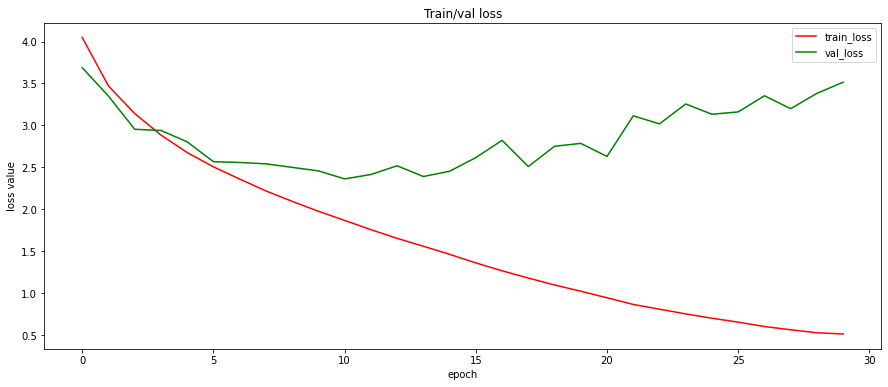

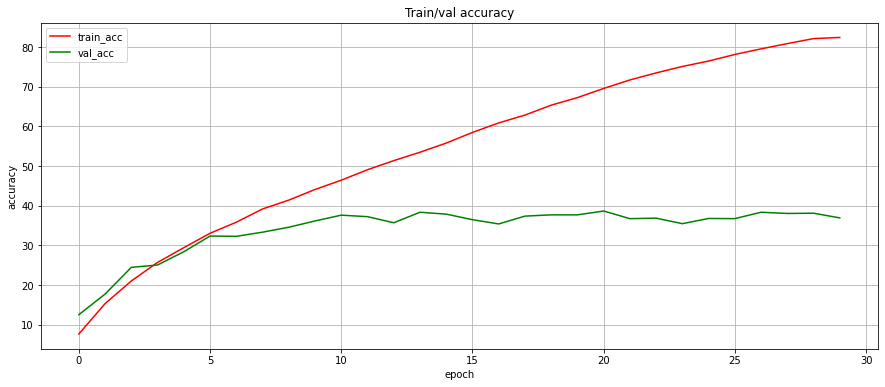

In [9]:
model_conv_lr_001=train_plot_learning_rate(0.0001)


Epoch 1/30: train_loss: 4.4673, train_accuracy: 2.4883, val_loss: 4.1488, val_accuracy: 4.7697



Epoch 2/30: train_loss: 4.1161, train_accuracy: 5.4850, val_loss: 3.8617, val_accuracy: 8.1963



Epoch 3/30: train_loss: 3.8428, train_accuracy: 8.8783, val_loss: 3.6681, val_accuracy: 11.2109



Epoch 4/30: train_loss: 3.6137, train_accuracy: 11.9100, val_loss: 3.4451, val_accuracy: 14.6106



Epoch 5/30: train_loss: 3.4378, train_accuracy: 14.5967, val_loss: 3.1723, val_accuracy: 19.1660



Epoch 6/30: train_loss: 3.2595, train_accuracy: 17.5433, val_loss: 3.0956, val_accuracy: 20.6766



Epoch 7/30: train_loss: 3.0918, train_accuracy: 20.5850, val_loss: 2.9559, val_accuracy: 23.8017



Epoch 8/30: train_loss: 2.9506, train_accuracy: 23.1350, val_loss: 2.9427, val_accuracy: 23.1184



Epoch 9/30: train_loss: 2.8150, train_accuracy: 25.7850, val_loss: 2.8384, val_accuracy: 25.7377



Epoch 10/30: train_loss: 2.6925, train_accuracy: 27.9717, val_loss: 2.6174, val_accuracy: 30.0452



Epoch 11/30: train_loss: 2.5720, train_accuracy: 30.5150, val_loss: 2.5129, val_accuracy: 32.2593



Epoch 12/30: train_loss: 2.4716, train_accuracy: 32.3633, val_loss: 2.6836, val_accuracy: 29.3050



Epoch 13/30: train_loss: 2.3687, train_accuracy: 34.4417, val_loss: 2.5110, val_accuracy: 33.1134



Epoch 14/30: train_loss: 2.2657, train_accuracy: 36.6667, val_loss: 2.4479, val_accuracy: 34.7714



Epoch 15/30: train_loss: 2.1737, train_accuracy: 38.5333, val_loss: 2.4382, val_accuracy: 35.0260



Epoch 16/30: train_loss: 2.0802, train_accuracy: 40.7733, val_loss: 2.4237, val_accuracy: 35.2169



Epoch 17/30: train_loss: 1.9988, train_accuracy: 42.3400, val_loss: 2.3419, val_accuracy: 37.5917



Epoch 18/30: train_loss: 1.9032, train_accuracy: 44.3467, val_loss: 2.2888, val_accuracy: 38.9148



Epoch 19/30: train_loss: 1.8210, train_accuracy: 45.8650, val_loss: 2.3767, val_accuracy: 37.4979



Epoch 20/30: train_loss: 1.7299, train_accuracy: 48.2317, val_loss: 2.3219, val_accuracy: 39.2129



Epoch 21/30: train_loss: 1.6507, train_accuracy: 50.0933, val_loss: 2.2930, val_accuracy: 39.7186



Epoch 22/30: train_loss: 1.5623, train_accuracy: 52.1017, val_loss: 2.4555, val_accuracy: 38.9114



Epoch 23/30: train_loss: 1.4912, train_accuracy: 53.8933, val_loss: 2.4612, val_accuracy: 38.9918



Epoch 24/30: train_loss: 1.4023, train_accuracy: 56.0233, val_loss: 2.3772, val_accuracy: 39.7220



Epoch 25/30: train_loss: 1.3260, train_accuracy: 57.8633, val_loss: 2.4399, val_accuracy: 40.3450



Epoch 26/30: train_loss: 1.2513, train_accuracy: 59.5900, val_loss: 2.7441, val_accuracy: 36.8682



Epoch 27/30: train_loss: 1.1812, train_accuracy: 61.7133, val_loss: 2.7259, val_accuracy: 38.2382



Epoch 28/30: train_loss: 1.1128, train_accuracy: 63.7533, val_loss: 2.7046, val_accuracy: 38.4023



Epoch 29/30: train_loss: 1.0488, train_accuracy: 65.3683, val_loss: 2.8615, val_accuracy: 38.3822



Epoch 30/30: train_loss: 0.9866, train_accuracy: 66.9800, val_loss: 2.7325, val_accuracy: 40.0033


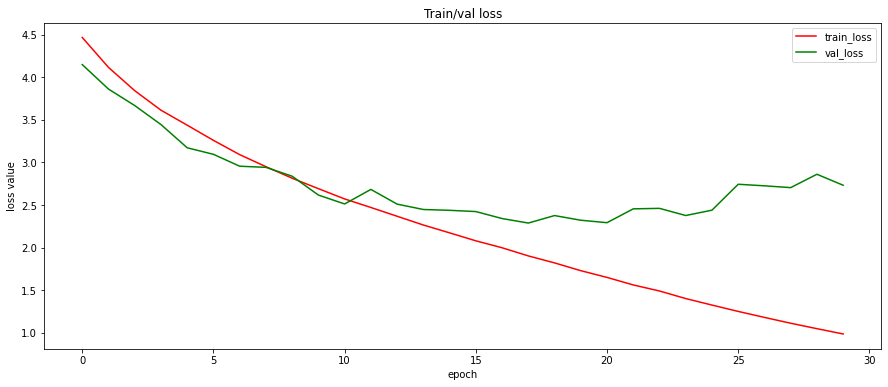

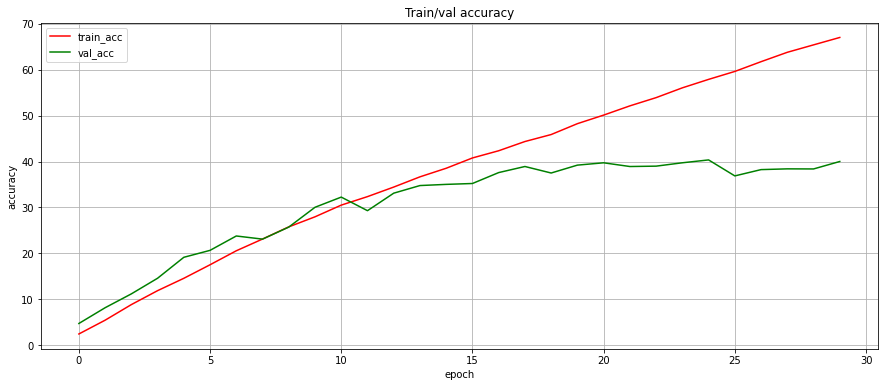

In [8]:
model_conv_lr_0005=train_plot_learning_rate(0.0005)

### Ablation 5: vary batch size
- batch size = 128: val_acc ~= 40%
- with batch size = 32, the accuracy was around 1%, I removed it from this notebook

In [0]:
def train_plot_batch_size(batch_size):

    train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8,pin_memory=True)
    val_dataloader = DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=8,pin_memory=True)

    model_conv_batch_size = ConvNet()
    model_conv_batch_size = model_conv_batch_size.to(device)

    optimizer_batch_size = torch.optim.Adam(model_conv_batch_size.parameters(), lr=learning_rate)

    train_losses_batch_size, val_losses_batch_size, train_accuracies_batch_size, val_accuracies_batch_size = train(model_conv_batch_size, train_dataloader, val_dataloader, optimizer_batch_size, n_epochs=n_epochs, loss_function=loss_fn)
    plot(n_epochs, train_losses_batch_size, val_losses_batch_size, train_accuracies_batch_size, val_accuracies_batch_size)
    return model_conv_batch_size


Epoch 1/30: train_loss: 4.6695, train_accuracy: 2.1650, val_loss: 4.3016, val_accuracy: 3.6041



Epoch 2/30: train_loss: 4.2649, train_accuracy: 4.0483, val_loss: 4.1461, val_accuracy: 5.7076



Epoch 3/30: train_loss: 4.0756, train_accuracy: 5.8900, val_loss: 3.9941, val_accuracy: 7.2115



Epoch 4/30: train_loss: 3.8493, train_accuracy: 8.7833, val_loss: 3.8480, val_accuracy: 9.2145



Epoch 5/30: train_loss: 3.6637, train_accuracy: 11.5183, val_loss: 3.7755, val_accuracy: 10.6247



Epoch 6/30: train_loss: 3.4919, train_accuracy: 13.8983, val_loss: 3.3904, val_accuracy: 15.9471



Epoch 7/30: train_loss: 3.3249, train_accuracy: 16.9717, val_loss: 3.1662, val_accuracy: 19.2866



Epoch 8/30: train_loss: 3.1747, train_accuracy: 19.3567, val_loss: 3.1838, val_accuracy: 20.5594



Epoch 9/30: train_loss: 3.0343, train_accuracy: 21.5200, val_loss: 2.9354, val_accuracy: 23.8888



Epoch 10/30: train_loss: 2.9036, train_accuracy: 23.9117, val_loss: 2.8386, val_accuracy: 25.4564



Epoch 11/30: train_loss: 2.7582, train_accuracy: 26.4967, val_loss: 2.6622, val_accuracy: 28.8896



Epoch 12/30: train_loss: 2.6448, train_accuracy: 28.9000, val_loss: 2.6151, val_accuracy: 30.1558



Epoch 13/30: train_loss: 2.5349, train_accuracy: 31.1367, val_loss: 2.6862, val_accuracy: 29.0873



Epoch 14/30: train_loss: 2.4252, train_accuracy: 33.4450, val_loss: 2.5012, val_accuracy: 32.6880



Epoch 15/30: train_loss: 2.3107, train_accuracy: 35.6100, val_loss: 2.4396, val_accuracy: 34.7111



Epoch 16/30: train_loss: 2.2059, train_accuracy: 37.9250, val_loss: 2.3124, val_accuracy: 37.2835



Epoch 17/30: train_loss: 2.0974, train_accuracy: 40.2150, val_loss: 2.3515, val_accuracy: 36.3758



Epoch 18/30: train_loss: 1.9979, train_accuracy: 42.4650, val_loss: 2.4085, val_accuracy: 36.2954



Epoch 19/30: train_loss: 1.8909, train_accuracy: 44.4583, val_loss: 2.3764, val_accuracy: 37.6252



Epoch 20/30: train_loss: 1.7831, train_accuracy: 47.2283, val_loss: 2.3140, val_accuracy: 39.1057



Epoch 21/30: train_loss: 1.6923, train_accuracy: 49.0150, val_loss: 2.2994, val_accuracy: 39.1392



Epoch 22/30: train_loss: 1.5888, train_accuracy: 51.4167, val_loss: 2.3069, val_accuracy: 40.0368



Epoch 23/30: train_loss: 1.4917, train_accuracy: 53.8983, val_loss: 2.4313, val_accuracy: 38.5195



Epoch 24/30: train_loss: 1.4213, train_accuracy: 55.8567, val_loss: 2.4350, val_accuracy: 38.9985



Epoch 25/30: train_loss: 1.3200, train_accuracy: 58.0717, val_loss: 2.5885, val_accuracy: 39.7689



Epoch 26/30: train_loss: 1.2306, train_accuracy: 60.4567, val_loss: 2.4914, val_accuracy: 40.3852



Epoch 27/30: train_loss: 1.1503, train_accuracy: 62.8900, val_loss: 2.6404, val_accuracy: 40.1608



Epoch 28/30: train_loss: 1.0639, train_accuracy: 65.1867, val_loss: 2.7667, val_accuracy: 39.1224



Epoch 29/30: train_loss: 1.0088, train_accuracy: 66.5667, val_loss: 2.7727, val_accuracy: 39.4507



Epoch 30/30: train_loss: 0.9367, train_accuracy: 68.8067, val_loss: 2.8377, val_accuracy: 40.6398


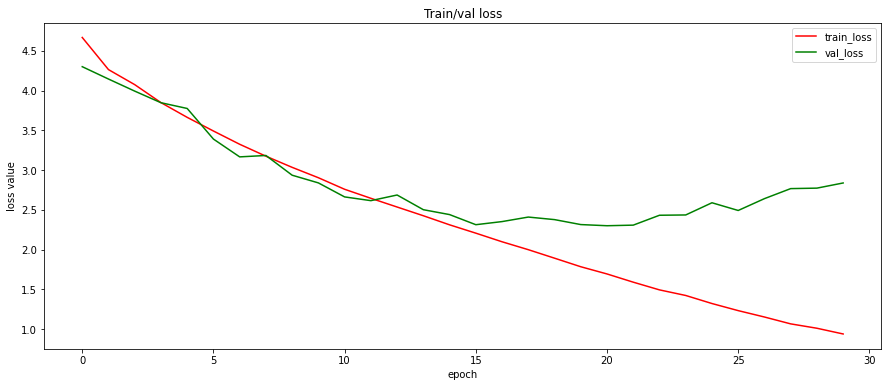

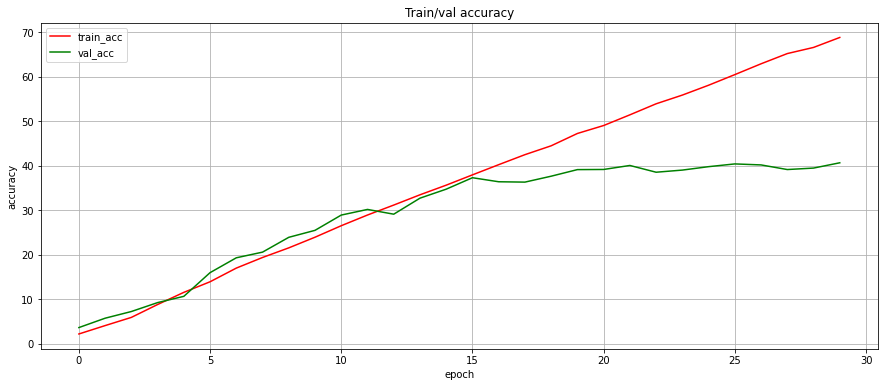

In [8]:
model_conv_batch_size_128=train_plot_batch_size(128)

### Ablation 6: reduce learning rate if val_acc doesn't increase for some epochs
- With Adam optimizer: val_acc ~= 41%
- With SGD and nesterov momentum: val_acc ~= 45%

In [0]:
def train_reduce_lr(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_function):
    # We will monitor loss functions as the training progresses
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max',factor=0.2,patience=3,threshold=0.5,verbose=True)

    # Run training for n_epochs
    for epoch in range(n_epochs):
        model.train()
        train_loss, train_accuracy = train_epoch(model, train_dataloader, optimizer, loss_fn)
        model.eval()
        val_loss, val_accuracy = evaluate(model, val_dataloader, loss_fn)
        scheduler.step(val_accuracy)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        print('Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                      train_losses[-1],
                                                                                                      train_accuracies[-1],
                                                                                                      val_losses[-1],
                                                                                                      val_accuracies[-1]))
    return train_losses, val_losses, train_accuracies, val_accuracies


Epoch 1/30: train_loss: 4.6114, train_accuracy: 2.0967, val_loss: 4.2385, val_accuracy: 3.7950



Epoch 2/30: train_loss: 4.1799, train_accuracy: 4.7200, val_loss: 4.0620, val_accuracy: 6.4210



Epoch 3/30: train_loss: 3.9122, train_accuracy: 8.0033, val_loss: 3.7137, val_accuracy: 10.9764



Epoch 4/30: train_loss: 3.6557, train_accuracy: 11.3800, val_loss: 3.4176, val_accuracy: 15.5451



Epoch 5/30: train_loss: 3.4172, train_accuracy: 15.2733, val_loss: 3.2664, val_accuracy: 17.3204



Epoch 6/30: train_loss: 3.2006, train_accuracy: 18.6150, val_loss: 3.0891, val_accuracy: 21.6011



Epoch 7/30: train_loss: 3.0068, train_accuracy: 22.1333, val_loss: 2.9128, val_accuracy: 24.5721



Epoch 8/30: train_loss: 2.8485, train_accuracy: 25.1167, val_loss: 2.7878, val_accuracy: 26.9101



Epoch 9/30: train_loss: 2.7024, train_accuracy: 28.2167, val_loss: 2.7141, val_accuracy: 28.3638



Epoch 10/30: train_loss: 2.5610, train_accuracy: 30.6667, val_loss: 2.5710, val_accuracy: 31.8037



Epoch 11/30: train_loss: 2.4334, train_accuracy: 33.4200, val_loss: 2.4723, val_accuracy: 33.5957



Epoch    12: reducing learning rate of group 0 to 2.0000e-04.
Epoch 12/30: train_loss: 2.3068, train_accuracy: 35.8000, val_loss: 2.4708, val_accuracy: 34.3929



Epoch 13/30: train_loss: 1.9663, train_accuracy: 43.3617, val_loss: 2.2266, val_accuracy: 39.4373



Epoch 14/30: train_loss: 1.8646, train_accuracy: 45.7833, val_loss: 2.2345, val_accuracy: 40.1139



Epoch 15/30: train_loss: 1.7959, train_accuracy: 47.3617, val_loss: 2.2295, val_accuracy: 40.1139



Epoch    16: reducing learning rate of group 0 to 4.0000e-05.
Epoch 16/30: train_loss: 1.7282, train_accuracy: 48.8650, val_loss: 2.2525, val_accuracy: 40.3350



Epoch 17/30: train_loss: 1.6208, train_accuracy: 51.3017, val_loss: 2.2529, val_accuracy: 40.9278



Epoch 18/30: train_loss: 1.5940, train_accuracy: 51.8367, val_loss: 2.2462, val_accuracy: 40.9747



Epoch 19/30: train_loss: 1.5746, train_accuracy: 52.4467, val_loss: 2.2574, val_accuracy: 41.0049



Epoch 20/30: train_loss: 1.5611, train_accuracy: 52.7167, val_loss: 2.2561, val_accuracy: 41.2192



Epoch    21: reducing learning rate of group 0 to 8.0000e-06.
Epoch 21/30: train_loss: 1.5489, train_accuracy: 52.9500, val_loss: 2.2524, val_accuracy: 41.2427



Epoch 22/30: train_loss: 1.5235, train_accuracy: 53.6917, val_loss: 2.2708, val_accuracy: 41.3901



Epoch 23/30: train_loss: 1.5152, train_accuracy: 53.9783, val_loss: 2.2735, val_accuracy: 41.2661



Epoch 24/30: train_loss: 1.5126, train_accuracy: 54.0550, val_loss: 2.2781, val_accuracy: 41.2125



Epoch    25: reducing learning rate of group 0 to 1.6000e-06.
Epoch 25/30: train_loss: 1.5092, train_accuracy: 53.9500, val_loss: 2.2694, val_accuracy: 41.2963



Epoch 26/30: train_loss: 1.5006, train_accuracy: 54.0617, val_loss: 2.2853, val_accuracy: 41.4537



Epoch 27/30: train_loss: 1.4962, train_accuracy: 54.2033, val_loss: 2.2759, val_accuracy: 41.3264



Epoch 28/30: train_loss: 1.5018, train_accuracy: 54.3033, val_loss: 2.2766, val_accuracy: 41.2527



Epoch    29: reducing learning rate of group 0 to 3.2000e-07.
Epoch 29/30: train_loss: 1.5030, train_accuracy: 54.1317, val_loss: 2.2891, val_accuracy: 41.3197



Epoch 30/30: train_loss: 1.4962, train_accuracy: 54.3350, val_loss: 2.2713, val_accuracy: 41.3599


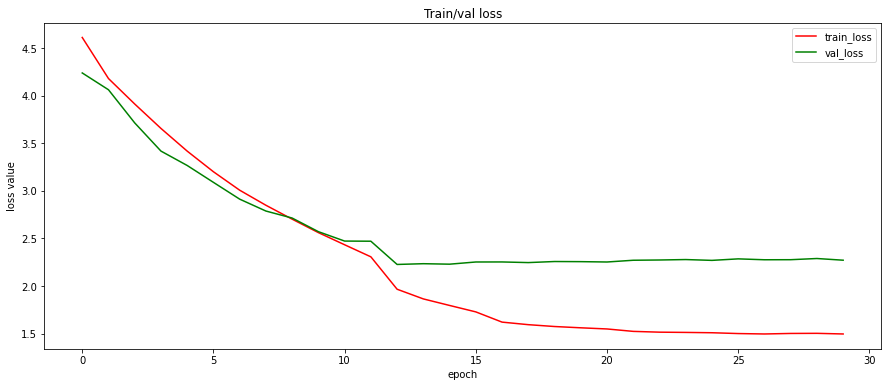

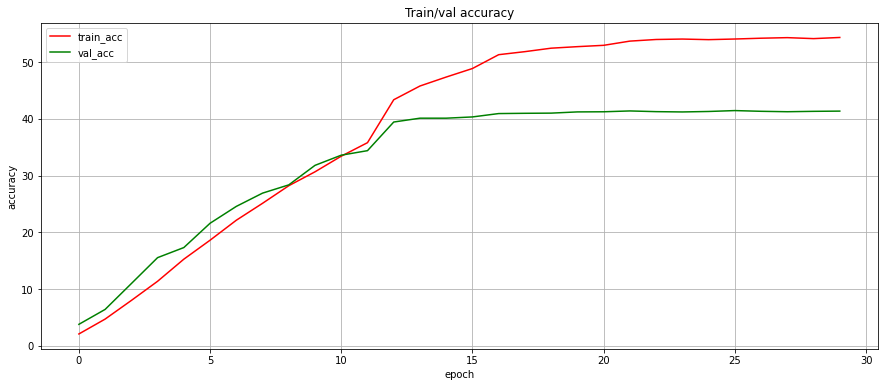

In [8]:
model_conv_reduce_lr = ConvNet()
model_conv_reduce_lr = model_conv_reduce_lr.to(device)

optimizer_reduce_lr = torch.optim.Adam(model_conv_reduce_lr.parameters(), lr=learning_rate)

train_losses_reduce_lr, val_losses_reduce_lr, train_accuracies_reduce_lr, val_accuracies_reduce_lr = train_reduce_lr(model_conv_reduce_lr, train_dataloader, val_dataloader, optimizer_reduce_lr, n_epochs=n_epochs, loss_function=loss_fn)
plot(n_epochs, train_losses_reduce_lr, val_losses_reduce_lr, train_accuracies_reduce_lr, val_accuracies_reduce_lr)


Epoch 1/30: train_loss: 4.1565, train_accuracy: 5.5450, val_loss: 3.8162, val_accuracy: 9.8777



Epoch 2/30: train_loss: 3.6404, train_accuracy: 12.1617, val_loss: 3.4411, val_accuracy: 15.5217



Epoch 3/30: train_loss: 3.3044, train_accuracy: 17.6100, val_loss: 3.2867, val_accuracy: 18.5731



Epoch 4/30: train_loss: 3.0279, train_accuracy: 22.3833, val_loss: 2.8971, val_accuracy: 24.9338



Epoch 5/30: train_loss: 2.7835, train_accuracy: 26.9383, val_loss: 2.7880, val_accuracy: 27.3522



Epoch 6/30: train_loss: 2.5733, train_accuracy: 31.4300, val_loss: 2.5702, val_accuracy: 31.0903



Epoch 7/30: train_loss: 2.3887, train_accuracy: 35.3300, val_loss: 2.6227, val_accuracy: 31.0400



Epoch     8: reducing learning rate of group 0 to 2.0000e-03.
Epoch 8/30: train_loss: 2.2152, train_accuracy: 39.1217, val_loss: 2.4482, val_accuracy: 34.6575



Epoch 9/30: train_loss: 1.7930, train_accuracy: 49.1717, val_loss: 2.1467, val_accuracy: 41.9829



Epoch 10/30: train_loss: 1.6702, train_accuracy: 51.9083, val_loss: 2.1312, val_accuracy: 42.3179



Epoch 11/30: train_loss: 1.5750, train_accuracy: 54.4167, val_loss: 2.1321, val_accuracy: 42.6461



Epoch 12/30: train_loss: 1.4883, train_accuracy: 56.2467, val_loss: 2.1845, val_accuracy: 42.3648



Epoch    13: reducing learning rate of group 0 to 4.0000e-04.
Epoch 13/30: train_loss: 1.4029, train_accuracy: 58.5767, val_loss: 2.2007, val_accuracy: 42.5892



Epoch 14/30: train_loss: 1.1738, train_accuracy: 64.6583, val_loss: 2.1492, val_accuracy: 44.7831



Epoch 15/30: train_loss: 1.1187, train_accuracy: 65.8483, val_loss: 2.1835, val_accuracy: 44.5654



Epoch 16/30: train_loss: 1.0819, train_accuracy: 66.8767, val_loss: 2.1801, val_accuracy: 44.5487



Epoch    17: reducing learning rate of group 0 to 8.0000e-05.
Epoch 17/30: train_loss: 1.0405, train_accuracy: 68.1967, val_loss: 2.1978, val_accuracy: 44.4649



Epoch 18/30: train_loss: 0.9767, train_accuracy: 70.0733, val_loss: 2.1929, val_accuracy: 44.8836



Epoch 19/30: train_loss: 0.9641, train_accuracy: 70.5867, val_loss: 2.1998, val_accuracy: 44.9841



Epoch 20/30: train_loss: 0.9585, train_accuracy: 70.7083, val_loss: 2.1960, val_accuracy: 44.8970



Epoch    21: reducing learning rate of group 0 to 1.6000e-05.
Epoch 21/30: train_loss: 0.9512, train_accuracy: 70.6900, val_loss: 2.2045, val_accuracy: 44.9104



Epoch 22/30: train_loss: 0.9331, train_accuracy: 71.4233, val_loss: 2.1995, val_accuracy: 45.0042



Epoch 23/30: train_loss: 0.9315, train_accuracy: 71.5067, val_loss: 2.2078, val_accuracy: 44.9707



Epoch 24/30: train_loss: 0.9355, train_accuracy: 71.2650, val_loss: 2.2048, val_accuracy: 45.0343



Epoch    25: reducing learning rate of group 0 to 3.2000e-06.
Epoch 25/30: train_loss: 0.9277, train_accuracy: 71.5000, val_loss: 2.2085, val_accuracy: 45.0042



Epoch 26/30: train_loss: 0.9263, train_accuracy: 71.5383, val_loss: 2.2126, val_accuracy: 44.9707



Epoch 27/30: train_loss: 0.9268, train_accuracy: 71.5667, val_loss: 2.2149, val_accuracy: 44.9606



Epoch 28/30: train_loss: 0.9296, train_accuracy: 71.4733, val_loss: 2.2018, val_accuracy: 44.8870



Epoch    29: reducing learning rate of group 0 to 6.4000e-07.
Epoch 29/30: train_loss: 0.9287, train_accuracy: 71.5583, val_loss: 2.2035, val_accuracy: 44.9506



Epoch 30/30: train_loss: 0.9229, train_accuracy: 71.7283, val_loss: 2.2087, val_accuracy: 44.9841


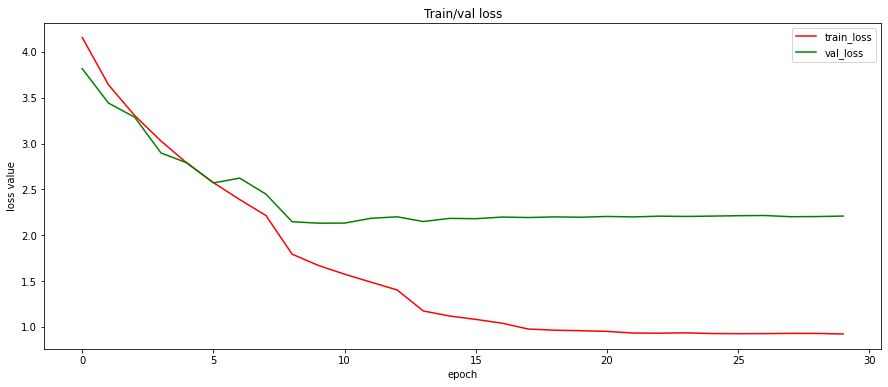

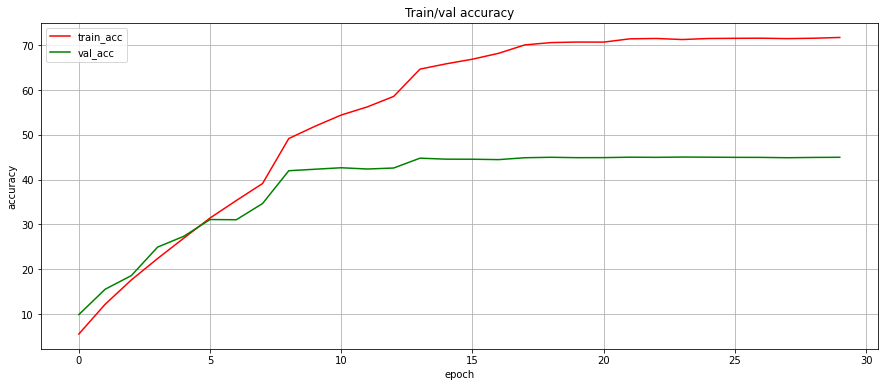

In [10]:
lr_001=0.01
model_conv_sgd_momentum_reduce_lr = ConvNet()
model_conv_sgd_momentum_reduce_lr =model_conv_sgd_momentum_reduce_lr.to(device)
sgd_momentum_optimizer_reduce_lr=torch.optim.SGD(model_conv_sgd_momentum_reduce_lr.parameters(),lr=lr_001,momentum=0.9,nesterov=True)

train_losses_sgd_momentum_reduce_lr, val_losses_sgd_momentum_reduce_lr, train_accuracies_sgd_momentum_reduce_lr, val_accuracies_sgd_momentum_reduce_lr = train_reduce_lr(model_conv_sgd_momentum_reduce_lr, train_dataloader, val_dataloader, sgd_momentum_optimizer_reduce_lr, n_epochs=n_epochs, loss_function=loss_fn)
plot(n_epochs,train_losses_sgd_momentum_reduce_lr, val_losses_sgd_momentum_reduce_lr, train_accuracies_sgd_momentum_reduce_lr, val_accuracies_sgd_momentum_reduce_lr)

### Final model: combine ablations that had a larger val_acc than the baseline at Task 3
- data augmentation (random horizontal flip + random vary brightness and contrast)
- SGD with nesterov momentum as optimizer 
- dynamically divide learning rate by 5, beginning with 0.01 if val_acc don't increase after 4 epochs
- return best model based on max(val_acc) (not necessary the last epoch)
- resulting val_acc after 25 epochs: ~49%

In [0]:
import copy
def train_plot_return_best(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_function):
    max_acc=0
    best_model_state_dict=None
    # We will monitor loss functions as the training progresses
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max',factor=0.2,patience=4,threshold=0.5,verbose=True)

    # Run training for n_epochs
    for epoch in range(n_epochs):
        model.train()
        train_loss, train_accuracy = train_epoch(model, train_dataloader, optimizer, loss_fn)
        model.eval()
        val_loss, val_accuracy = evaluate(model, val_dataloader, loss_fn)
        if val_accuracy > max_acc:
            max_acc=val_accuracy
            best_model_state_dict=copy.deepcopy(model.state_dict())
        scheduler.step(val_accuracy)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        print('Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                    train_losses[-1],
                                                                                                    train_accuracies[-1],
                                                                                                    val_losses[-1],
                                                                                                    val_accuracies[-1]))
    plot(n_epochs,train_losses, val_losses, train_accuracies, val_accuracies)
    model_best=ConvNet()
    model_best=model_best.to(device)
    model_best.load_state_dict(best_model_state_dict)
    return model_best


Epoch 1/25: train_loss: 4.3441, train_accuracy: 3.8567, val_loss: 4.0106, val_accuracy: 7.1412



Epoch 2/25: train_loss: 3.9337, train_accuracy: 8.2083, val_loss: 3.6411, val_accuracy: 12.3832



Epoch 3/25: train_loss: 3.6073, train_accuracy: 12.5300, val_loss: 3.3768, val_accuracy: 16.5500



Epoch 4/25: train_loss: 3.3334, train_accuracy: 16.8467, val_loss: 3.2066, val_accuracy: 19.5445



Epoch 5/25: train_loss: 3.0923, train_accuracy: 21.3233, val_loss: 2.8734, val_accuracy: 25.4028



Epoch 6/25: train_loss: 2.8769, train_accuracy: 25.2717, val_loss: 2.8052, val_accuracy: 27.5063



Epoch 7/25: train_loss: 2.6986, train_accuracy: 28.8683, val_loss: 2.6013, val_accuracy: 30.8692



Epoch 8/25: train_loss: 2.5408, train_accuracy: 32.0917, val_loss: 2.4516, val_accuracy: 34.1350



Epoch 9/25: train_loss: 2.4050, train_accuracy: 35.0833, val_loss: 2.4749, val_accuracy: 34.6207



Epoch 10/25: train_loss: 2.2860, train_accuracy: 37.7433, val_loss: 2.3387, val_accuracy: 36.4629



Epoch 11/25: train_loss: 2.1770, train_accuracy: 39.9967, val_loss: 2.3042, val_accuracy: 37.7123



Epoch    12: reducing learning rate of group 0 to 2.0000e-03.
Epoch 12/25: train_loss: 2.0723, train_accuracy: 42.4333, val_loss: 2.1729, val_accuracy: 40.8206



Epoch 13/25: train_loss: 1.7523, train_accuracy: 49.9783, val_loss: 1.9558, val_accuracy: 46.0861



Epoch 14/25: train_loss: 1.6591, train_accuracy: 52.3800, val_loss: 1.9523, val_accuracy: 46.4244



Epoch 15/25: train_loss: 1.6061, train_accuracy: 53.7683, val_loss: 1.9447, val_accuracy: 46.9536



Epoch 16/25: train_loss: 1.5606, train_accuracy: 54.9650, val_loss: 1.9572, val_accuracy: 46.7225



Epoch 17/25: train_loss: 1.5161, train_accuracy: 56.0183, val_loss: 1.9673, val_accuracy: 46.3942



Epoch 18/25: train_loss: 1.4792, train_accuracy: 56.8550, val_loss: 1.9592, val_accuracy: 46.9302



Epoch    19: reducing learning rate of group 0 to 4.0000e-04.
Epoch 19/25: train_loss: 1.4255, train_accuracy: 58.3500, val_loss: 1.9571, val_accuracy: 46.9670



Epoch 20/25: train_loss: 1.2961, train_accuracy: 61.6583, val_loss: 1.9268, val_accuracy: 48.4676



Epoch 21/25: train_loss: 1.2567, train_accuracy: 62.5667, val_loss: 1.9263, val_accuracy: 48.5480



Epoch 22/25: train_loss: 1.2381, train_accuracy: 63.2367, val_loss: 1.9262, val_accuracy: 48.6217



Epoch 23/25: train_loss: 1.2207, train_accuracy: 63.5900, val_loss: 1.9425, val_accuracy: 48.7557



Epoch    24: reducing learning rate of group 0 to 8.0000e-05.
Epoch 24/25: train_loss: 1.2067, train_accuracy: 63.8867, val_loss: 1.9341, val_accuracy: 48.9365



Epoch 25/25: train_loss: 1.1691, train_accuracy: 65.0883, val_loss: 1.9353, val_accuracy: 49.0471


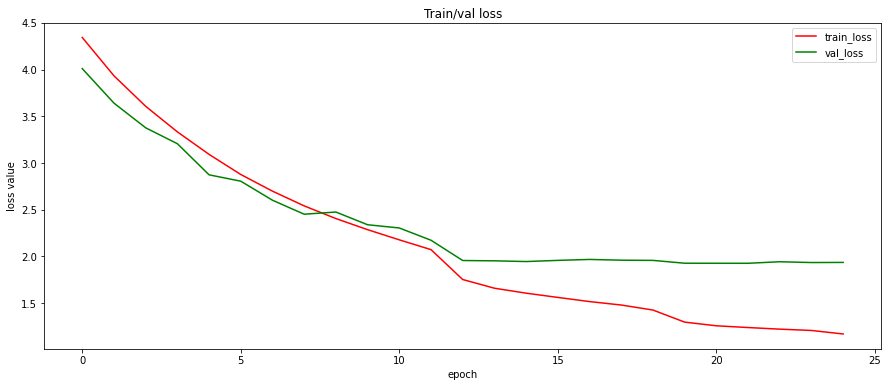

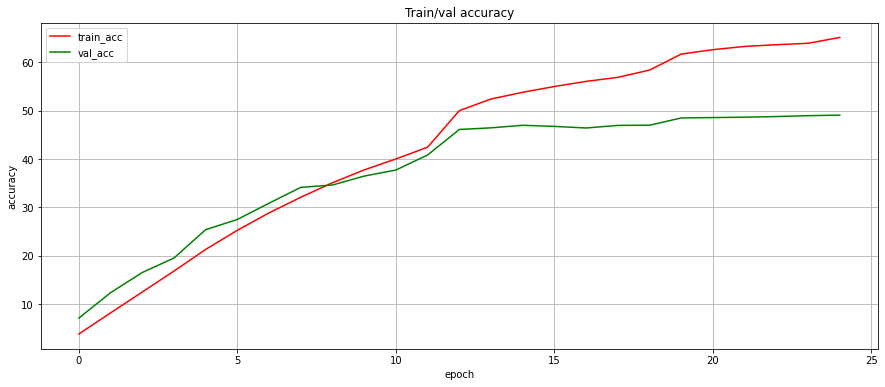

In [20]:
lr_001=0.01
model_best = ConvNet()
model_best =model_best.to(device)
model_best_optimizer=torch.optim.SGD(model_best.parameters(),lr=lr_001,momentum=0.9,nesterov=True)

model_best=train_plot_return_best(model_best, train_data_augmented_dataloader, val_dataloader, model_best_optimizer, n_epochs=25, loss_function=loss_fn)

## Task 5. Model Errors
Evaluate the trained model on the validation set and plot 10 random mistakes that your model made.

In [0]:
def evaluate_get_incorrect_predictions(model, dataloader):
    # list of tuples: (tensor/image, label)
    incorrect_predictions=[]
    # Iterate mini batches over validation dataset
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            # Run predictions
            output = model(images)
            predictions=output.argmax(1).cpu().numpy()
            for i in range(len(predictions)):
                if predictions[i]!=labels[i]:
                    incorrect_predictions.append((images[i],labels[i].item()))

    # Return incorrect predictions
    return incorrect_predictions

In [22]:
incorrect_predictions=evaluate_get_incorrect_predictions(model_best, val_dataloader)

In [60]:
from collections import Counter
import glob

class_count=Counter()
for i in range(100):
    class_count[i]=len(glob.glob(validation_dir+f'/{i}/*.jpg'))

incorrect_predictions_counter=Counter()
for _, label in incorrect_predictions:
    incorrect_predictions_counter[label]+=1
    
print(f'{len(incorrect_predictions_counter)} classes had errors:')

for label,count in incorrect_predictions_counter.most_common():
    print(f'\tClass {label}: {count} errors ({(1-count/class_count[label])*100}% accuracy)')

100 classes had errors:
	Class 40: 244 errors (18.666666666666664% accuracy)
	Class 65: 243 errors (18.999999999999993% accuracy)
	Class 18: 228 errors (24.0% accuracy)
	Class 62: 224 errors (25.33333333333333% accuracy)
	Class 13: 223 errors (25.66666666666667% accuracy)
	Class 70: 222 errors (26.0% accuracy)
	Class 19: 218 errors (27.333333333333332% accuracy)
	Class 66: 216 errors (28.000000000000004% accuracy)
	Class 55: 216 errors (28.000000000000004% accuracy)
	Class 20: 216 errors (28.000000000000004% accuracy)
	Class 32: 213 errors (29.000000000000004% accuracy)
	Class 44: 212 errors (29.333333333333332% accuracy)
	Class 11: 210 errors (30.000000000000004% accuracy)
	Class 39: 209 errors (30.333333333333336% accuracy)
	Class 25: 208 errors (30.666666666666664% accuracy)
	Class 38: 208 errors (30.666666666666664% accuracy)
	Class 54: 203 errors (32.333333333333336% accuracy)
	Class 1: 202 errors (32.666666666666664% accuracy)
	Class 52: 202 errors (32.666666666666664% accuracy)


In [0]:
def show_image(tensor):
    plt.imshow((tensor.cpu().numpy().transpose(1,2,0)+1)/2)
    plt.show()

Class 33:


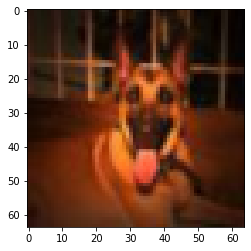

Class 19:


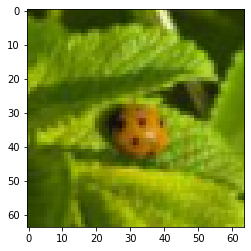

Class 19:


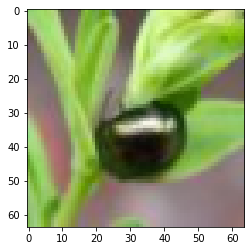

Class 69:


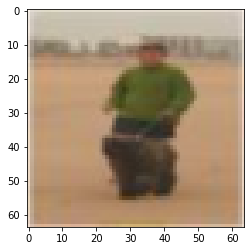

Class 42:


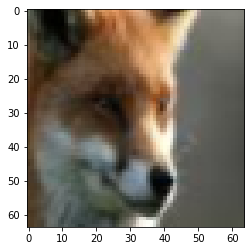

Class 37:


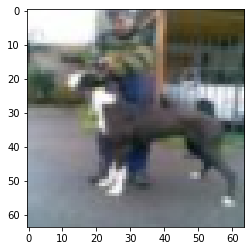

Class 0:


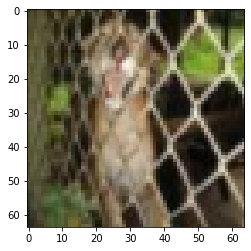

Class 10:


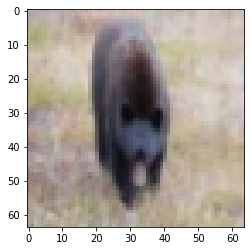

Class 79:


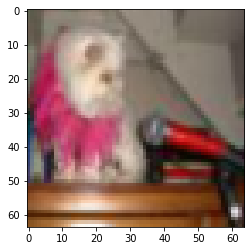

Class 98:


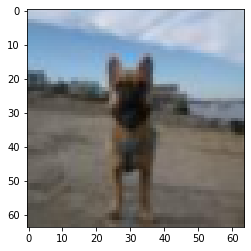

In [25]:
import random
random.shuffle(incorrect_predictions)
for img,label in incorrect_predictions[:10]:
    print(f'Class {label}:')
    show_image(img)

## Task 6. Competition time!
Read the images from "data/test" folder. There are no labels for these images. Run your best model on these images and save the image IDs (names) and predicted label in a file LastName.csv. You will receive a link via email to upload the CSV file to  an online system which will give you the score of your model on the held-out test set. Top 5 students with at least 40% classification accuracy will obtain bonus points.

In [0]:
def test(model,dataloader):
    model.eval()
    y_pred=np.array([],dtype=int)

    with torch.no_grad():
        for images in dataloader:
            images = images.to(device)
            output = model(images)
            for y in output.argmax(1).cpu().numpy():
                y_pred=np.append(y_pred,y)

    return y_pred

In [0]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

In [18]:
import glob
from PIL import Image
test_dir='data/test'
test_files = glob.glob(test_dir+'/*.jpg') 
images=[]
ids=[]
for file in tqdm(test_files):
    ids.append(file.split('/')[-1].split('.')[0])
    temp = Image.open(file)
    keep = temp.copy()
    images.append(transform(keep))
    temp.close()


In [0]:
test_dataset=TestDataset(images)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

In [0]:
predictions=dict(zip(ids,test(model_best,test_loader)))

In [0]:
with open('Goloviatinski.csv', 'w') as f:
    f.write('id,label\n')
    for id, pred in predictions.items():
        f.write(f'{id},{pred}\n')